# Imports

In [5]:
import pandas as pd
import numpy as np
import os

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from numpy.random import normal, uniform, shuffle

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, auc
from sklearn.ensemble import RandomForestRegressor

import dill

import itertools

In [6]:
%matplotlib inline

In [9]:
# dill.dump_session('cache/RandomForest_LD_only.db')

In [3]:
dill.load_session('cache/RandomForest_LD_only.db')

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# data_path = 'drive/My Drive/Colab Notebooks/NIR/data/'

In [7]:
data_path = 'data/not_cutted/'

In [8]:
results_path = 'not_cutted/'

# Data reading

## Reading

### Synth data for model building

In [9]:
X_train = pd.read_csv(data_path + 'X_train.csv')
X_test = pd.read_csv(data_path + 'X_test.csv')

Y_train = pd.read_csv(data_path + 'y_train.csv')
Y_test = pd.read_csv(data_path + 'y_test.csv')

### Real data for analysis

In [10]:
conditions = ['LD']

In [11]:
X_real = {}
Y_real = {}
for cond in conditions:
    X_real[cond] = pd.read_csv(data_path + 'real_X_' + cond + '.csv')
    Y_real[cond] = pd.read_csv(data_path + 'real_Y_' + cond + '.csv')

In [12]:
X_real['LD']

AP1      FD  FTa1  FTa2  FTa3  FTb  FTc    LFY   TFL1a   TFL1c  days
0      2   31.53     2     8   0.9    3    0    6.4  22.021  25.556     9
1      0   47.62     0    11   0.5    7    0   12.1  20.489  25.263    11
2      6   45.41     1    29   0.8    6    0   21.4  27.397  32.982    13
3      5   40.89     5    60  10.2   28    0   56.8  33.074  39.708    15
4     23   79.47     9    50   1.3   12    0   77.1  42.561  32.222    17
5     33   71.69    40    86   2.5   58    0   48.9  54.798  67.895    20
6      1   25.86    10    18   3.4    7    0   16.0   8.314  11.930    22
7     92   43.31    10    68   4.7  127    0   45.1  18.325  25.731    25
8     19   45.20    10    37   2.1   61    0   27.7  15.851  18.713    28
9    355   81.78     6    52  14.8  102   14   50.9  22.232  29.766    30
10   117   36.26     1    16   3.0   13    0   63.7  11.323  15.029    32
11   649   63.59    29    62  90.4  140    0  124.2  24.033  31.462    34
12   691   81.78     6    34   6.8   25    0  126.1  15.465  19.240    37
13  1025  112.37    41   116  32.2   73    2   95.7  16.039  40.877    40

In [52]:
Y_real['LD']['days'] = X_real['LD'].days.tolist()[1:] + [43]

###  STDs

In [14]:
stds = {}
for cond in conditions:
    stds[cond] = pd.read_csv('data/prepared/' + f'stds_{cond}.csv')
#     stds[cond] = stds[cond].drop(0)
#     stds[cond] = stds[cond].drop(FTs, axis = 1)

## Check the data

In [15]:
X_train.tail()

AP1          FD       FTa1        FTa2       FTa3         FTb  \
10495  1142.383171  124.308987  60.103208  108.954885  64.643059  118.276640   
10496  1125.379119  129.533123  42.282671   72.225361  18.192752  120.822540   
10497   913.243372  121.616115  50.597257  137.401418  37.957560  193.567952   
10498   927.937845  113.683253  79.613641  191.165970  25.922575   96.481229   
10499   723.421211  130.918064  92.127296  183.460837  29.465426  146.642053   

             FTc         LFY      TFL1a      TFL1c  days  
10495  58.236883   42.558380  14.840402  63.050527    40  
10496  50.061259   20.732368  15.570294  28.529618    40  
10497  63.745091   93.447017  15.956044  21.821392    40  
10498   3.263528   91.364769  19.207152  43.013165    40  
10499  49.651023  105.361903  13.379711  31.317699    40

In [16]:
len(X_train[X_train.days == 30].AP1)

750

In [17]:
175/750

0.23333333333333334

In [20]:
X_train.days.value_counts()

15    750
30    750
22    750
37    750
13    750
28    750
20    750
11    750
34    750
25    750
17    750
9     750
40    750
32    750
Name: days, dtype: int64

In [21]:
Y_train.tail()

AP1         FD        LFY      TFL1a      TFL1c  days
10495  324.977074  35.462732  22.307590  12.329714  10.100769    43
10496  237.949089  28.906198  13.275744  10.297313  11.154931    43
10497  166.356671  19.734852  27.883067   8.006526   5.664446    43
10498  165.702187  14.416278  22.488110   7.965664   3.709989    43
10499  202.424421  29.197826  15.745750   9.520392   7.010613    43

In [22]:
days = list(set(X_test.days.values))
days.append(40)
days.sort()
days

[9, 11, 13, 15, 17, 20, 22, 25, 28, 30, 32, 34, 37, 40, 40]

In [23]:
X = X_train.drop('days', axis=1)
Y = Y_train.drop('days', axis=1)

In [24]:
targets = Y.columns.tolist()
targets

['AP1', 'FD', 'LFY', 'TFL1a', 'TFL1c']

In [25]:
X_test.tail()

AP1          FD       FTa1        FTa2       FTa3         FTb  \
3495   948.909181  156.897880  71.765002  158.045251  23.385896  158.104297   
3496  1381.269139  117.973591  60.373238   95.006085  42.015397   37.841169   
3497  1014.710290  117.046417  93.527963  109.824509  25.817558  262.501706   
3498   769.747036   86.019381  43.253476   96.998946  40.059669   57.446012   
3499   651.303065  127.141983  31.456800  152.517260  34.174354   66.028849   

            FTc         LFY      TFL1a      TFL1c  days  
3495  34.875644   86.002793  20.215293  19.031290    40  
3496  27.450321  120.220295  18.702251  54.575844    40  
3497  29.541089  139.683576  14.985462  24.072334    40  
3498  32.903534   83.574475  19.956615  13.406652    40  
3499  28.863113   70.865558  14.365386  50.535956    40

# Random forest

## Model building

In [26]:
def GridS(model, grid, cv, **kwargs):
    return GridSearchCV(model, grid, 
                      n_jobs=-1, 
                      scoring=['neg_mean_squared_error', 'r2'], 
                      refit='neg_mean_squared_error', 
#                       scoring = MSE5,
#                       refit = MSE5,
                      cv=cv, 
                      verbose=10)

### Rough tuning

In [27]:
model = RandomForestRegressor()

cv = KFold(n_splits=5, shuffle=True)
grid = {
    'n_estimators': [20, 50, 100, 300],
    'min_samples_leaf': [10, 20, 50, 100],
    'max_depth': [5, 8, 20, None]
}

In [28]:
gs = GridS(model, grid, cv)

In [29]:
gs.fit(X.values, Y.values)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  7

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [20, 50, 100, 300], 'min_samples_leaf': [10, 20, 50, 100], 'max_depth': [5, 8, 20, None]},
       pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
       return_train_score='warn', scoring=['neg_mean_squared_error', 'r2'],
       verbose=10)

In [30]:
gs.best_params_

{'max_depth': 20, 'min_samples_leaf': 10, 'n_estimators': 300}

### Fine tuning (в итоге вряд ли нужен)

In [24]:
model = RandomForestRegressor()

cv = KFold(n_splits=5, shuffle=True)
grid = {
    'n_estimators': [250, 300, 350],
    'min_samples_leaf': [5, 10, 15],
    'max_depth': [15, 20, 25, None]
}

gs = GridS(model, grid, cv)

gs.fit(X.values, Y.values)

In [1]:
gs.best_params_

NameError: name 'gs' is not defined

Get the model with best score on the cross-validation:

### Save the model

In [34]:
best_model = gs.best_estimator_

In [31]:
with open('cache/Random_forest_LD_only.md', 'wb') as ouf:
    dill.dump(best_model, ouf)

## Make predictions

In [35]:
predictions_train = best_model.predict(X.values)
predictions_test = best_model.predict(X_test.drop('days', axis=1).values)

## Evaluating

In [31]:
def print_scores(true_values, predictions, s_name = 'sheet1'):
    MSEs = mean_squared_error(true_values.values, predictions, multioutput='raw_values').round(2)
    NRMSE = (np.sqrt(MSEs) / np.amax(true_values, axis=0)).round(3)
    R2 = r2_score(true_values.values, predictions, multioutput='raw_values').round(2)
    r = [] 
    for i in range(len(targets)):
        r.append(np.corrcoef(true_values.values.transpose()[i], predictions.transpose()[i]).round(2)[0, 1])
    df = pd.DataFrame({'MSE': MSEs, 'NRMSE': NRMSE,'R2': R2, 'r': r}, index=targets, )
    
    '''это старая версия, стоит добавить сохранение в эксель:
    раскомментить это и везде далее при вызове метода указывать в s_name, что ты сохраняешь'''
#     xl_writer = pd.ExcelWriter('eval.xlsx', engine='xlsxwriter')
#     df.to_excel(xl_writer, sheet_name=s_name)
#     xl_writer.save()
    
    return df

In [5]:
def comparsion_plot(true_values, predictions, data_type = 'train', current_target=targets[0], s=3, format='svg'):
    plt.scatter(true_values, predictions, s=s)
    plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'r')
    plt.xlabel('True Values' + ' (' + current_target + ')')
    plt.ylabel('Predictions' + ' (' + current_target + ')')
    plt.axis('equal')
    plt.axis('square')
    plt.title('Predictions on ' + data_type)
    
    if not os.path.exists(results_path):
        os.makedirs(results_path)
    
    plt.savefig(results_path + current_target + '_' + data_type + f'.{format}', bbox_inches='tight', format=format, dpi=300)
    plt.show()

Scores on train:  
(r - Pearson correlation)

In [26]:
print_scores(Y, predictions_train)

MSE  NRMSE    R2     r
AP1    9239.14  0.042  0.92  0.96
FD      148.49  0.061  0.79  0.89
LFY     554.16  0.084  0.72  0.85
TFL1a    33.09  0.058  0.83  0.91
TFL1c    43.87  0.063  0.81  0.90

Scores on test:

In [27]:
print_scores(Y_test.drop('days', axis=1), predictions_test)

MSE  NRMSE    R2     r
AP1    20536.37  0.073  0.82  0.90
FD       192.04  0.075  0.74  0.86
LFY      757.73  0.111  0.65  0.81
TFL1a     41.64  0.071  0.78  0.89
TFL1c     53.56  0.081  0.77  0.88

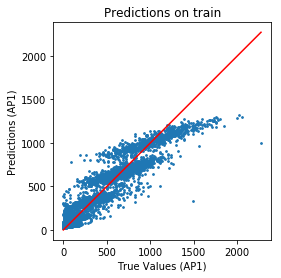

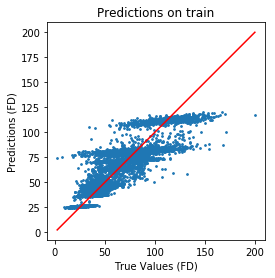

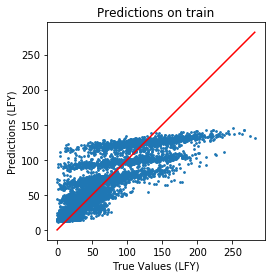

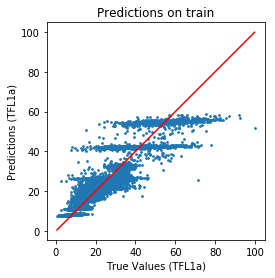

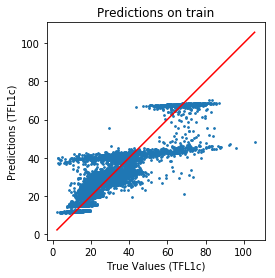

In [6]:
for i in range(5):
    comparsion_plot(Y.iloc[:, i], predictions_train[:, i], data_type='train', current_target=targets[i])

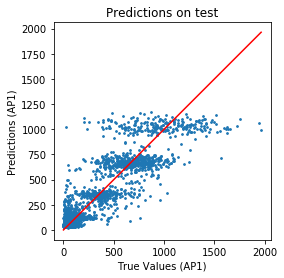

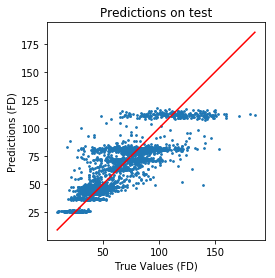

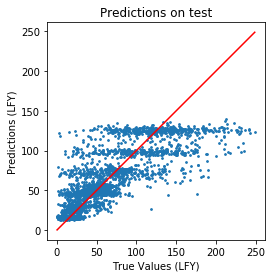

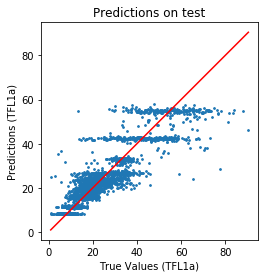

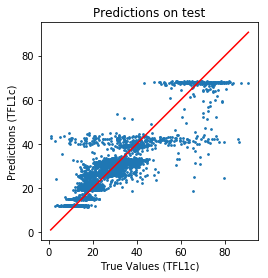

In [7]:
for i in range(5):
    comparsion_plot(Y_test.drop('days', axis=1).iloc[:, i], predictions_test[:, i], data_type='test', current_target=targets[i])

## Feature importances

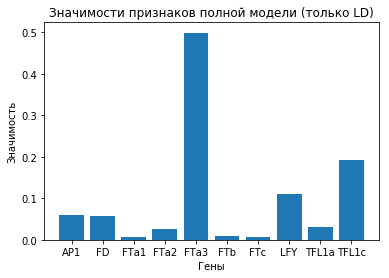

In [38]:
plt.bar(x = genes, height = best_model.feature_importances_)
plt.title('Значимости признаков полной модели (только LD)')
plt.xlabel('Гены')
plt.ylabel('Значимость')
plt.savefig(results_path + 'feature_importances')

In [37]:
genes = X.columns
genes

Index(['AP1', 'FD', 'FTa1', 'FTa2', 'FTa3', 'FTb', 'FTc', 'LFY', 'TFL1a',
       'TFL1c'],
      dtype='object')

# Real data

In [45]:
def time_long_plot(true_values, predicted, condition = 'LD', predict_method = 'static'):
    
    for i in range(5):
        
        plt.errorbar(true_values['days'], true_values.iloc[:,i], stds[condition][targets].iloc[:,i][1:],
                     marker='o', linestyle = '', capsize=3)
        
        plt.plot(true_values['days'], predicted.iloc[:, i].values, '-')
        
        plt.title(targets[i] + ' ' + condition + f' ({predict_method} prediction method)')
        plt.xlabel('days')
        plt.ylabel('rltv expr lvl')
        plt.legend(['predictions', 'true values'])
        
        fig_path = results_path + predict_method + '/'
        
        if not os.path.exists(fig_path):
            os.makedirs(fig_path)
        
        plt.savefig(fig_path + f'/{targets[i]}_{condition}_pred_on_real.svg', 
                    bbox_inches='tight', format='svg')
        plt.show()

In [51]:
Y_real['LD']

AP1      FD    LFY   TFL1a   TFL1c  days
0      0   47.62   12.1  20.489  25.263    11
1      6   45.41   21.4  27.397  32.982    13
2      5   40.89   56.8  33.074  39.708    15
3     23   79.47   77.1  42.561  32.222    17
4     33   71.69   48.9  54.798  67.895    20
5      1   25.86   16.0   8.314  11.930    22
6     92   43.31   45.1  18.325  25.731    25
7     19   45.20   27.7  15.851  18.713    28
8    355   81.78   50.9  22.232  29.766    30
9    117   36.26   63.7  11.323  15.029    32
10   649   63.59  124.2  24.033  31.462    34
11   691   81.78  126.1  15.465  19.240    37
12  1025  112.37   95.7  16.039  40.877    40
13   223   25.23   25.5  10.577  10.058    40

In [40]:
def predict(data):
    
    predictions = pd.DataFrame(best_model.predict(data.values), columns = targets)
     
    return predictions

## Static

In [41]:
predictions_real = {}
predictions_real['LD'] = best_model.predict(X_real['LD'].drop('days', axis=1).values)

In [49]:
predictions_real['LD'] = pd.DataFrame(predictions_real['LD'], columns=targets)

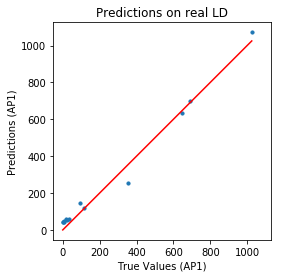

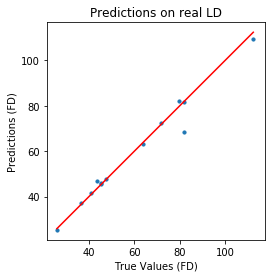

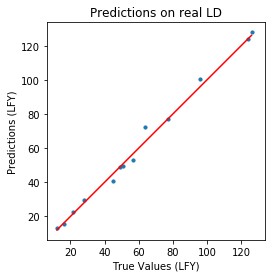

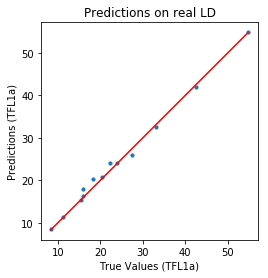

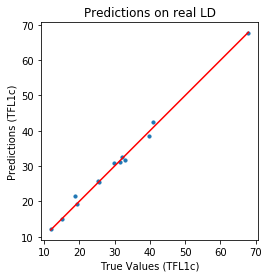

In [10]:
for cond in conditions:
    for i in range(5):
        comparsion_plot(Y_real[cond].iloc[:, i], predictions_real_static[cond][:, i], data_type='real ' + cond, current_target=targets[i], s=10)

In [42]:
print_scores(Y_real[cond].drop('days', axis=1), predictions_real_static[cond])

NameError: name 'print_scores' is not defined

In [11]:
for cond in conditions:
    predictions_real[cond] = pd.DataFrame(predictions_real[cond], columns=targets)

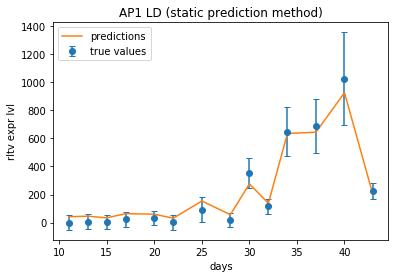

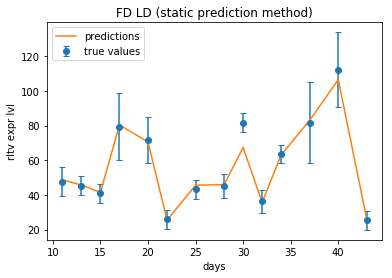

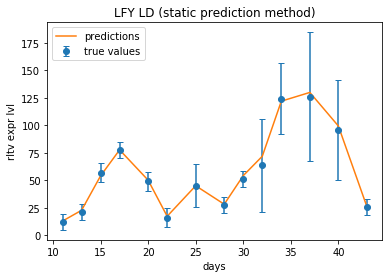

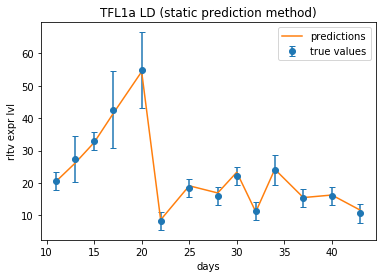

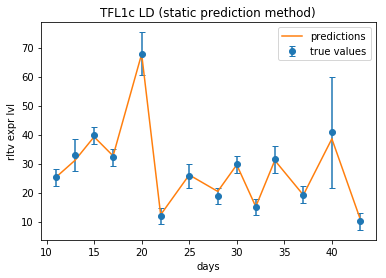

In [53]:
for cond in conditions:
    time_long_plot(Y_real[cond], predictions_real[cond], cond)

## Dynamic

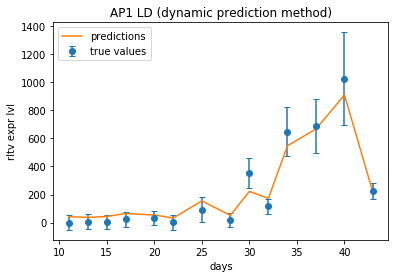

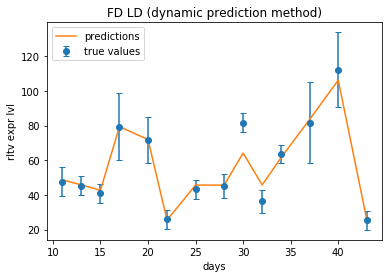

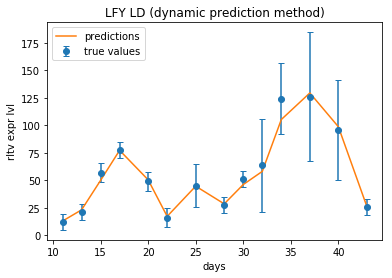

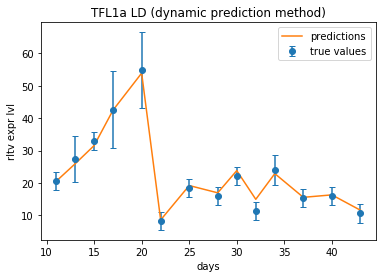

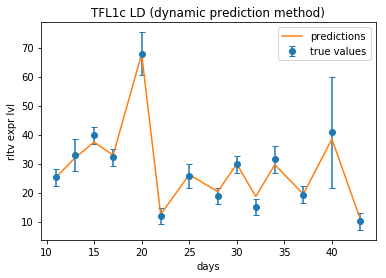

In [54]:
for cond in conditions:

    X_temp = X_real[cond].drop('days', axis = 1)

    predictions_real[cond] = pd.DataFrame(columns=targets)

    for i in X_real[cond].index:
        current_predictions = predict(X_temp.loc[[i]])
        predictions_real[cond] = predictions_real[cond].append(current_predictions, ignore_index = True)
        X_temp[targets] = current_predictions.values[0]

    time_long_plot(Y_real[cond], predictions_real[cond], cond, 'dynamic')

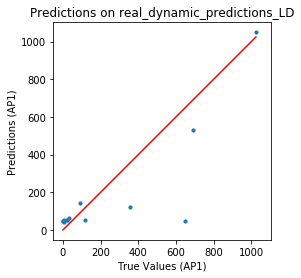

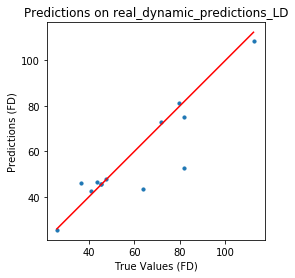

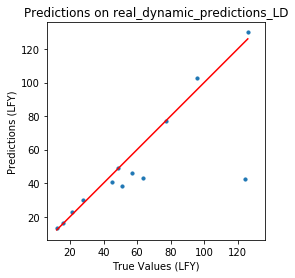

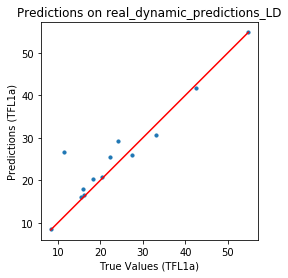

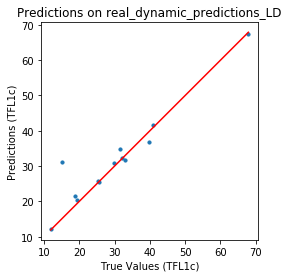

In [21]:
for cond in conditions:
    for i in range(5):
        comparsion_plot(Y_real[cond].iloc[:, i], predictions_real[cond].iloc[:, i], data_type='real_dynamic_predictions_' + cond, current_target=targets[i], s=10)

In [29]:
def print_scores(true_values, predictions):
    MSEs = mean_squared_error(true_values.values, predictions.values, multioutput='raw_values').round(2)
    NRMSE = (np.sqrt(MSEs) / np.amax(true_values, axis=0)).round(3)
    R2 = r2_score(true_values.values, predictions.values, multioutput='raw_values').round(2)
    r = [] 
    for i in range(len(targets)):
        r.append(np.corrcoef(true_values.values.transpose()[i], predictions.values.transpose()[i]).round(2)[0, 1])
    df = pd.DataFrame({'MSE': MSEs, 'NRMSE': NRMSE,'R2': R2, 'r': r}, index=targets, )
    return df

In [51]:
for cond in conditions:
    print(cond)
    print(print_scores(Y_real[cond].drop('days', axis=1), predictions_real[cond]))

LD
            MSE    R2     r
AP1    35505.07  0.67  0.84
FD       110.84  0.80  0.90
LFY      573.89  0.57  0.80
TFL1a     22.33  0.86  0.94
TFL1c     22.86  0.88  0.95


In [30]:
print_scores(Y_real[cond].drop('days', axis=1), predictions_real[cond])

MSE  NRMSE    R2     r
AP1    35505.07  0.184  0.67  0.84
FD       110.84  0.094  0.80  0.90
LFY      573.89  0.190  0.57  0.80
TFL1a     22.33  0.086  0.86  0.94
TFL1c     22.86  0.070  0.88  0.95

# Knock out simulation

## Methods definitions

In [24]:
def time_long_plot_ko(true_values, predicted, pred_for_ko, KO_gene, condition, predict_method = 'dynamic'):
    x_axis = true_values['days']
    
    for i in range(5):        
        
        plt.errorbar(true_values['days'], true_values.iloc[:,i], stds[condition].iloc[:,i],
                     marker='o', linestyle = '', capsize=3)
        
        plt.plot(x_axis, predicted.iloc[:, i], '--')
        plt.plot(x_axis, pred_for_ko[:, i], '-')
        
        if type(KO_gene) == type(''):
            KO_name = KO_gene
        else:            
            KO_name = '_'.join(KO_gene)

        plt.title(targets[i] + f' ({condition} with {KO_gene} KO)') # for correct title
        plt.xlabel('days')
        plt.ylabel('rltv expr lvl')
        plt.legend(['predictions on WT', 'predictions with KO', 'true values'])
        
        if type(KO_gene) != type(''):
            KO_number = len(KO_gene)
        else:
            KO_number = 1
        
        fig_path = results_path + f'{predict_method}/KOs/{targets[i]}/{KO_number}/'
        
        if not os.path.exists(fig_path):
            os.makedirs(fig_path)
        
        plt.savefig(fig_path + f'{targets[i]}_{condition}_with_{KO_gene}_KO.svg', 
                    bbox_inches='tight', format = 'svg')
        plt.show()

## KO Iterations set

In [74]:
targets_with_cond = [name + '_LD' for name in targets]

In [75]:
targets_with_cond

['AP1_LD', 'FD_LD', 'LFY_LD', 'TFL1a_LD', 'TFL1c_LD']

In [76]:
genes = X_real['LD'].drop('days', axis=1).columns.tolist()

In [77]:
genes

['AP1', 'FD', 'FTa1', 'FTa2', 'FTa3', 'FTb', 'FTc', 'LFY', 'TFL1a', 'TFL1c']

In [78]:
targets

['AP1', 'FD', 'LFY', 'TFL1a', 'TFL1c']

In [79]:
FTs = [name for name in genes if name.startswith('FT')]
FTs

['FTa1', 'FTa2', 'FTa3', 'FTb', 'FTc']

In [80]:
def FTs_combos(massive = FTs, number = 2):
    
    FTset = []
    comb = list(itertools.combinations(massive, number))
    
    for c in comb:
        FTset.append(list(c))

    return FTset

In [81]:
FT_pairs = FTs_combos(FTs, 2)
FT_pairs

[['FTa1', 'FTa2'],
 ['FTa1', 'FTa3'],
 ['FTa1', 'FTb'],
 ['FTa1', 'FTc'],
 ['FTa2', 'FTa3'],
 ['FTa2', 'FTb'],
 ['FTa2', 'FTc'],
 ['FTa3', 'FTb'],
 ['FTa3', 'FTc'],
 ['FTb', 'FTc']]

In [82]:
FT_trios = FTs_combos(FTs, 3)
FT_trios

[['FTa1', 'FTa2', 'FTa3'],
 ['FTa1', 'FTa2', 'FTb'],
 ['FTa1', 'FTa2', 'FTc'],
 ['FTa1', 'FTa3', 'FTb'],
 ['FTa1', 'FTa3', 'FTc'],
 ['FTa1', 'FTb', 'FTc'],
 ['FTa2', 'FTa3', 'FTb'],
 ['FTa2', 'FTa3', 'FTc'],
 ['FTa2', 'FTb', 'FTc'],
 ['FTa3', 'FTb', 'FTc']]

In [83]:
FT_quads = FTs_combos(FTs, 4)
FT_quads

[['FTa1', 'FTa2', 'FTa3', 'FTb'],
 ['FTa1', 'FTa2', 'FTa3', 'FTc'],
 ['FTa1', 'FTa2', 'FTb', 'FTc'],
 ['FTa1', 'FTa3', 'FTb', 'FTc'],
 ['FTa2', 'FTa3', 'FTb', 'FTc']]

In [84]:
KO_iterations = [targets, FTs, FT_pairs, FT_trios, FT_quads]

## KO simulations

In [22]:
AUC = pd.DataFrame(0, index=targets_with_cond, columns=['WT'])

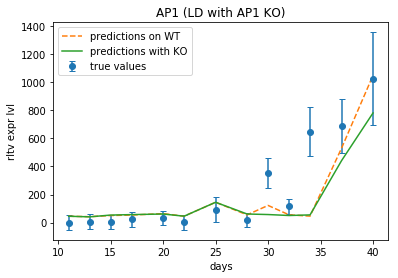

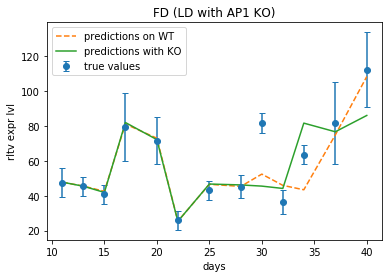

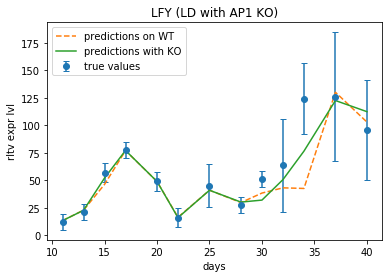

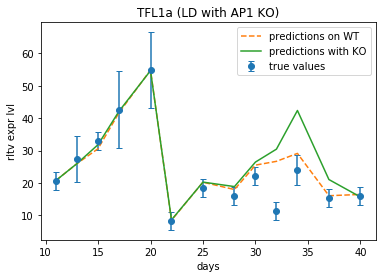

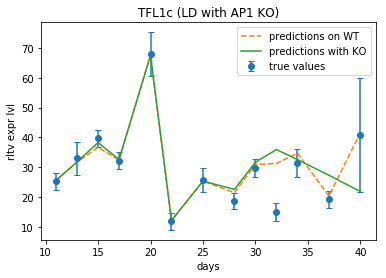

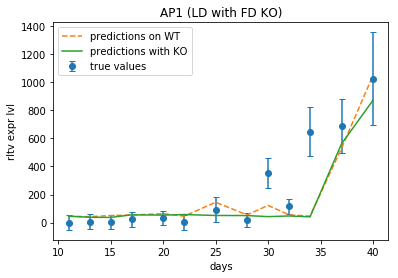

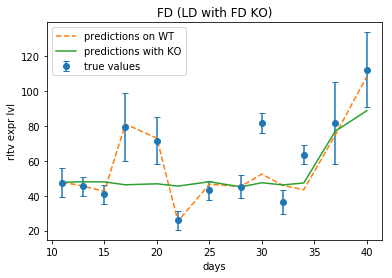

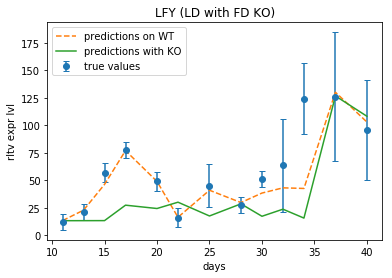

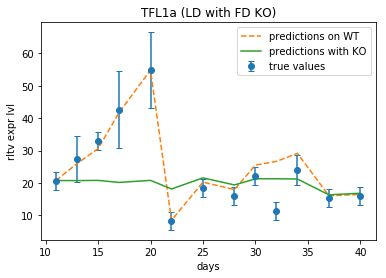

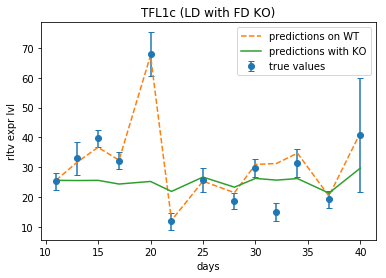

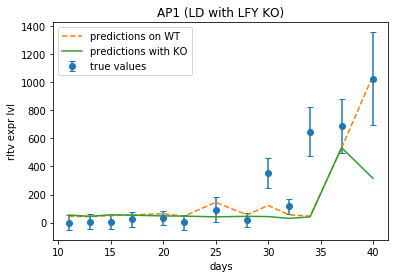

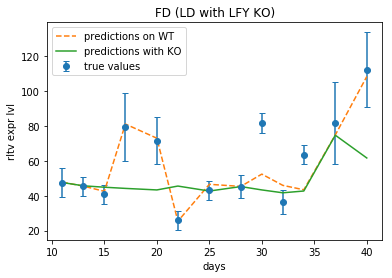

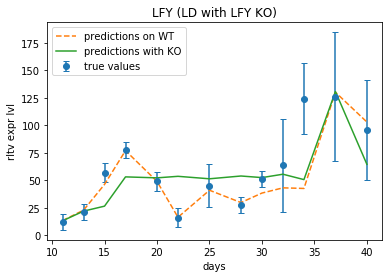

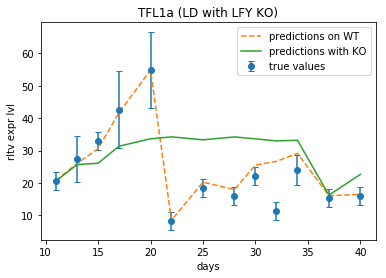

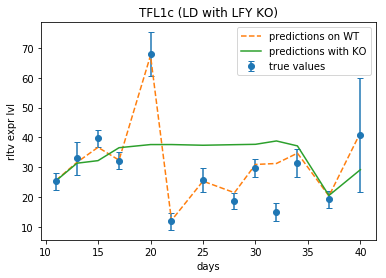

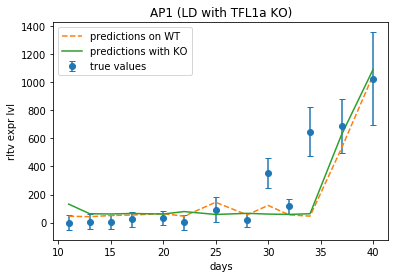

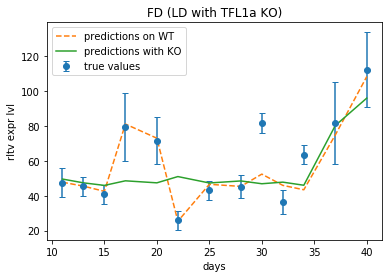

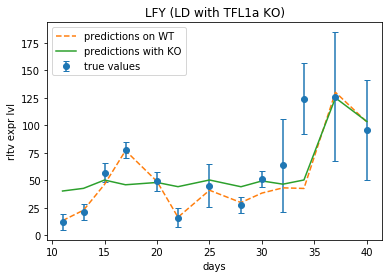

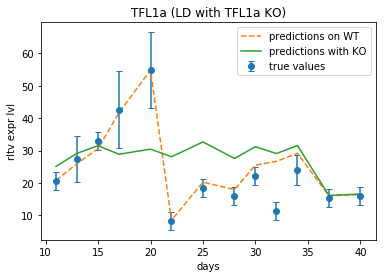

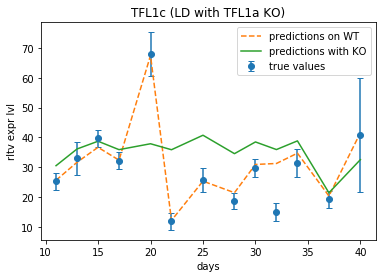

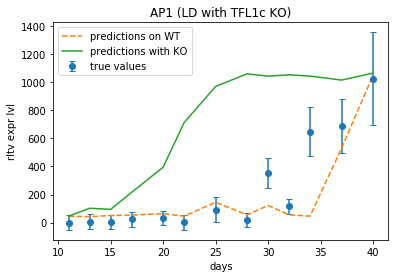

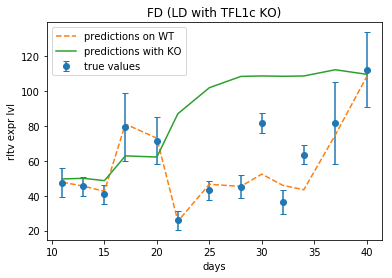

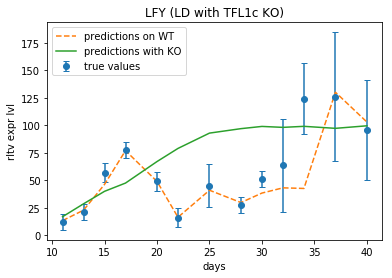

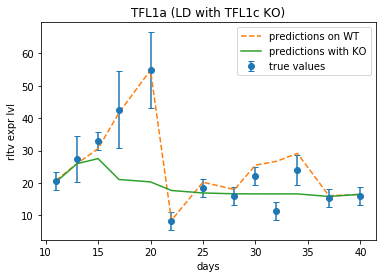

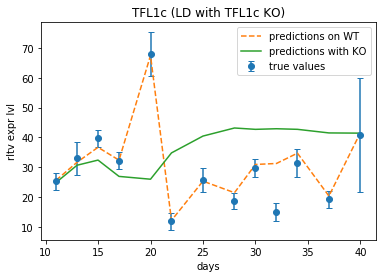

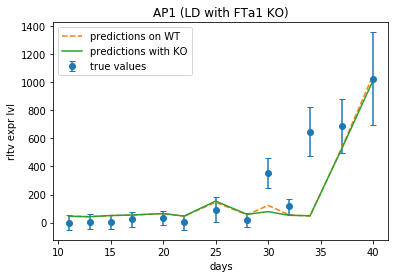

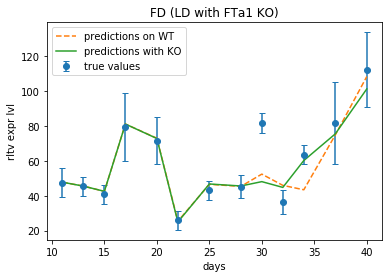

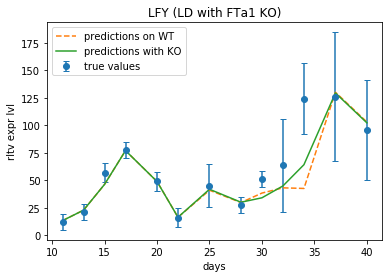

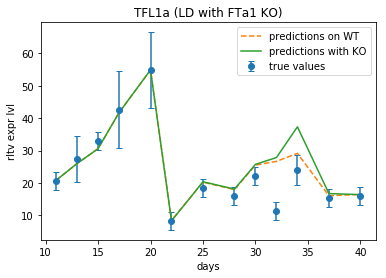

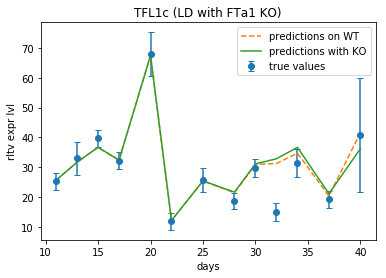

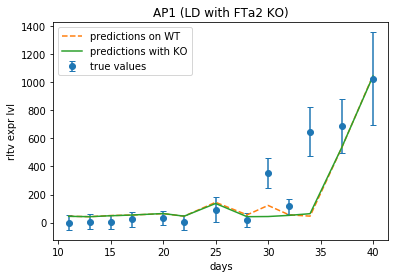

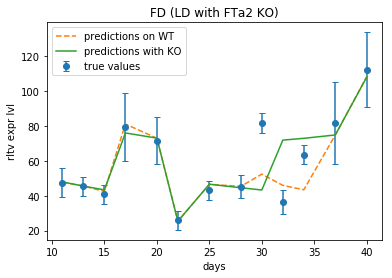

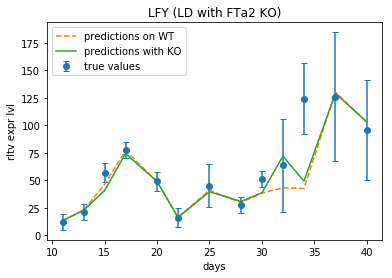

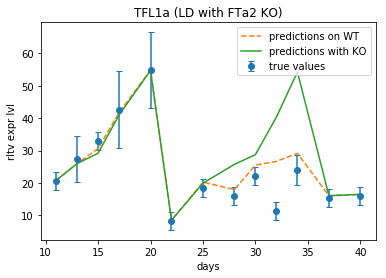

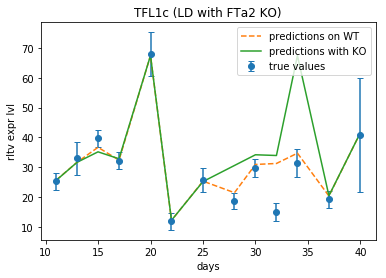

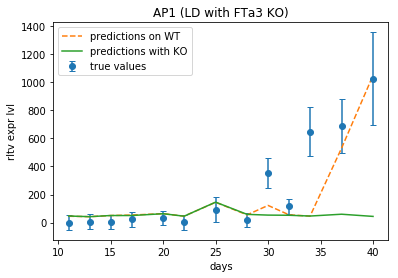

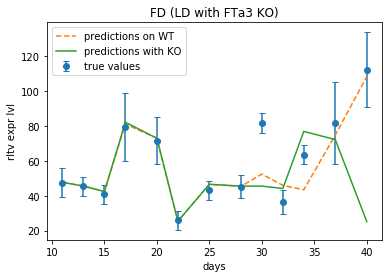

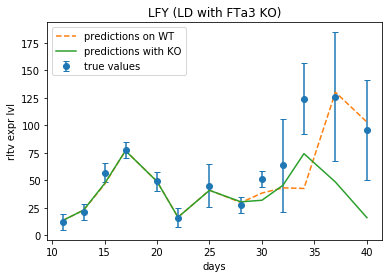

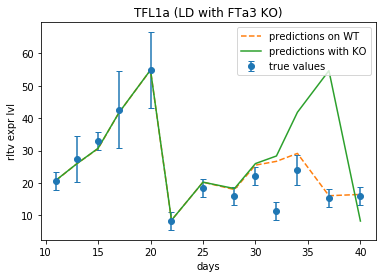

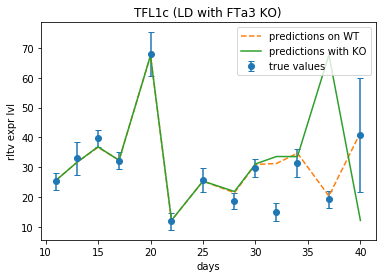

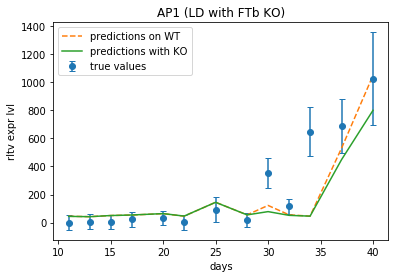

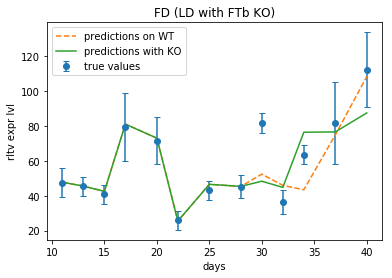

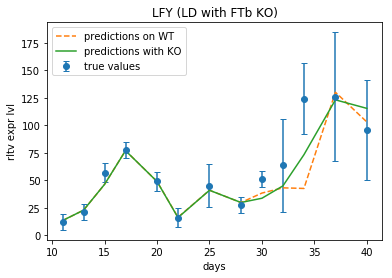

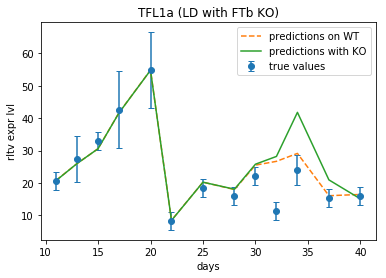

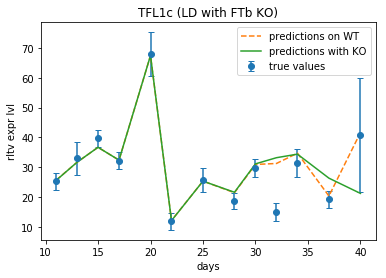

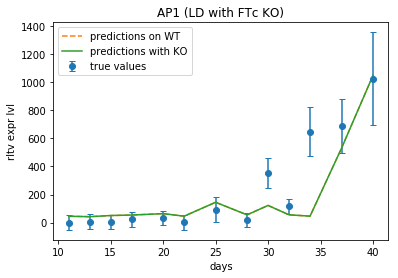

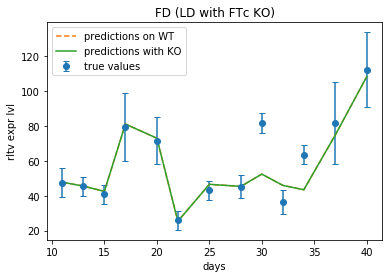

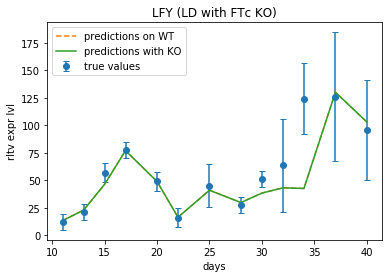

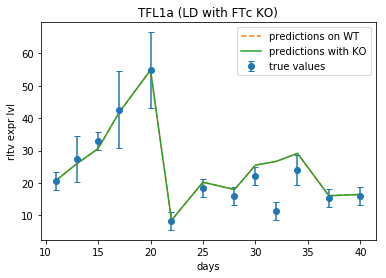

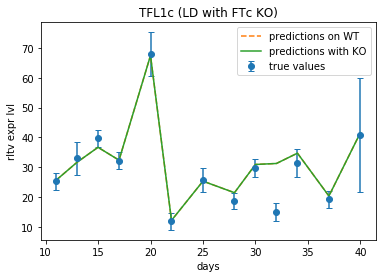

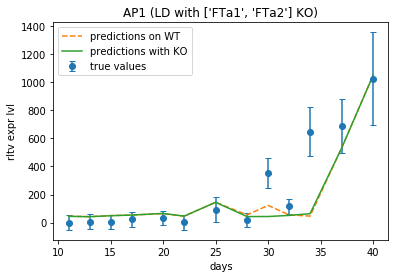

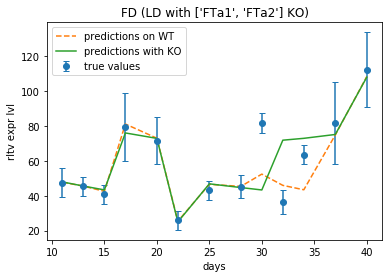

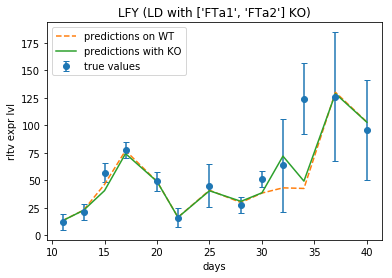

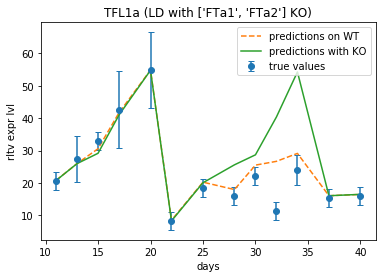

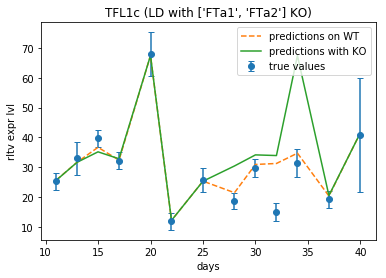

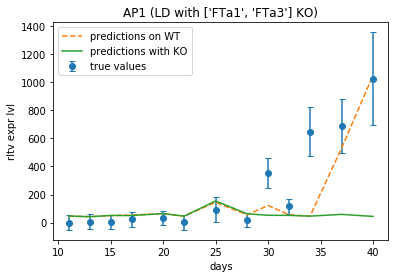

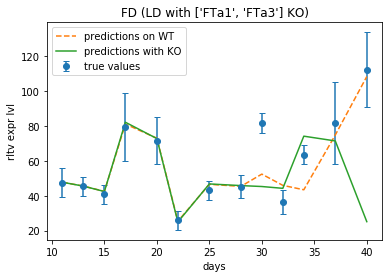

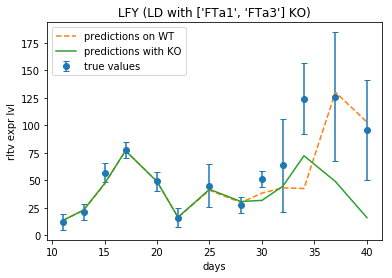

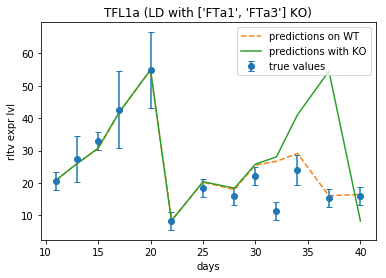

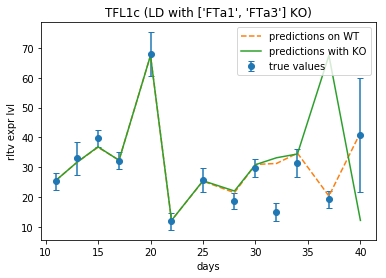

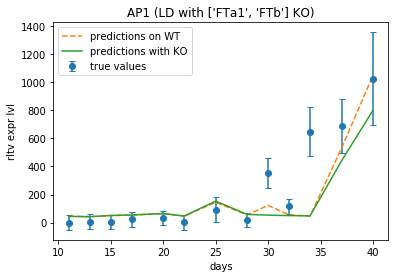

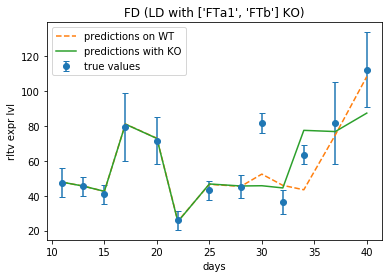

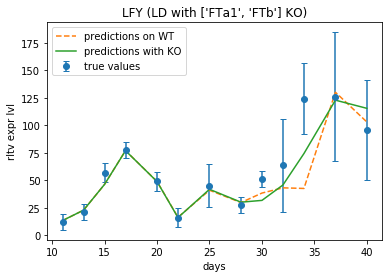

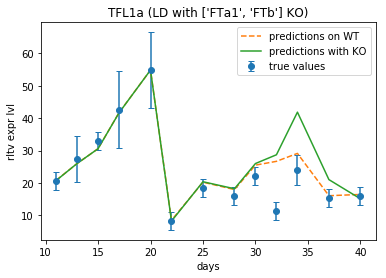

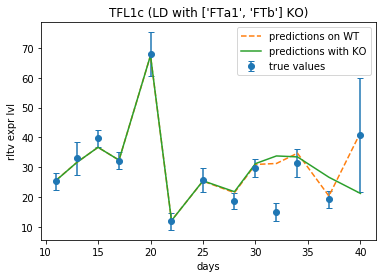

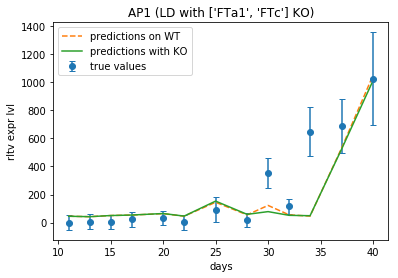

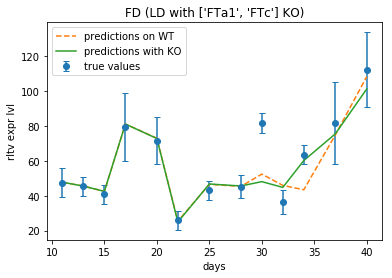

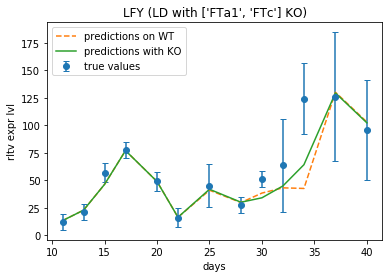

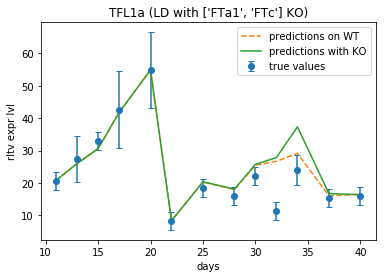

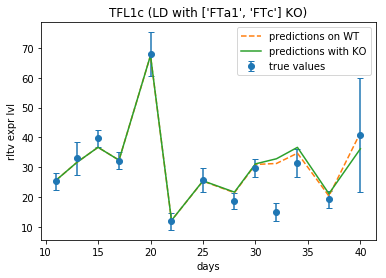

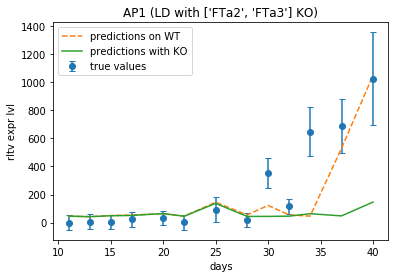

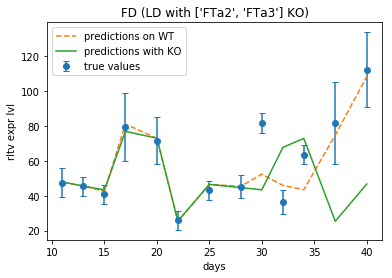

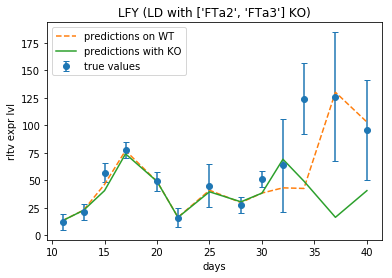

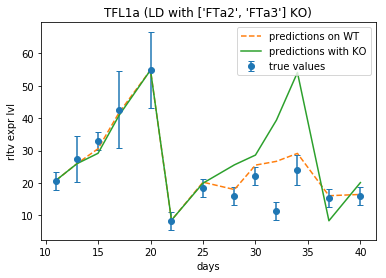

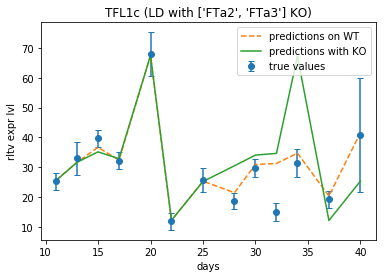

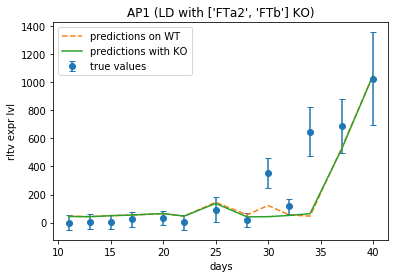

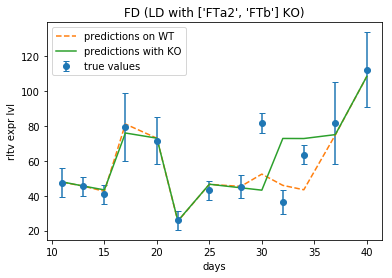

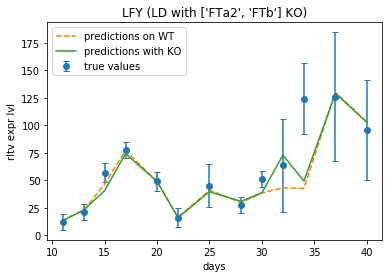

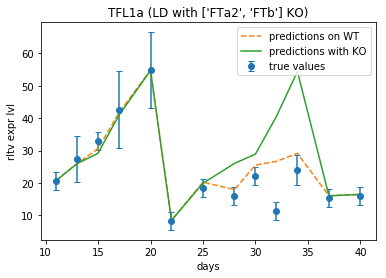

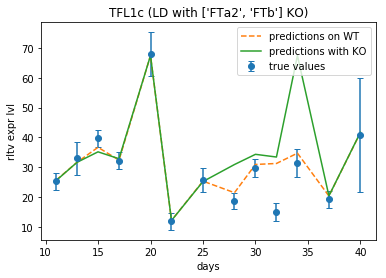

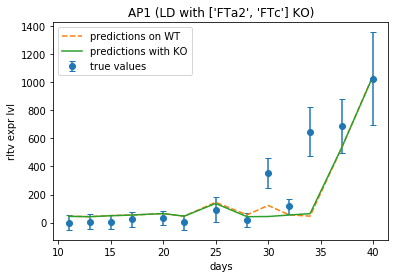

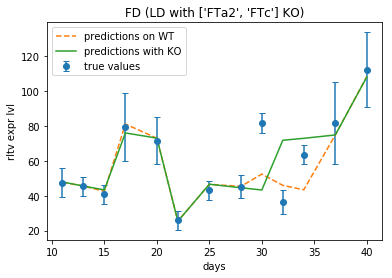

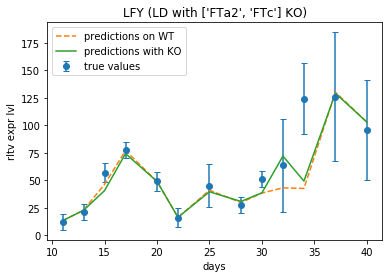

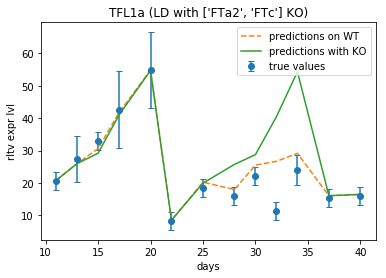

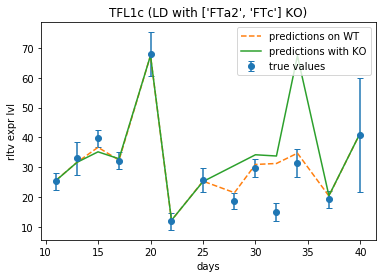

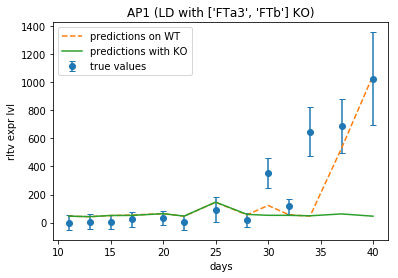

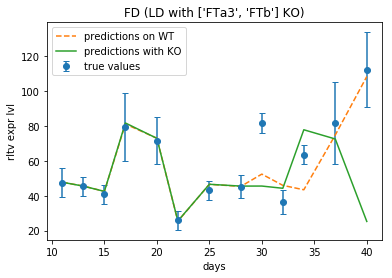

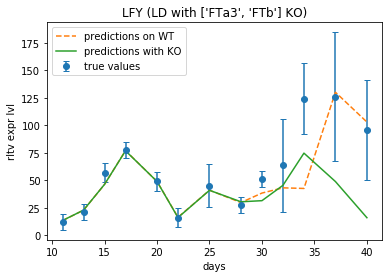

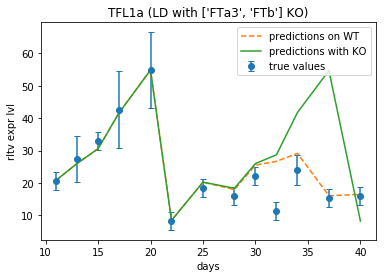

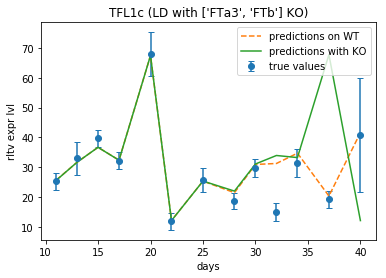

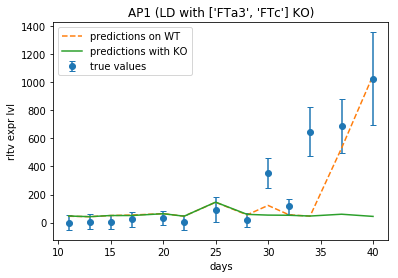

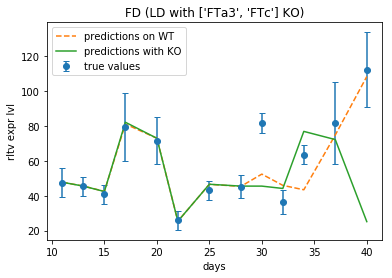

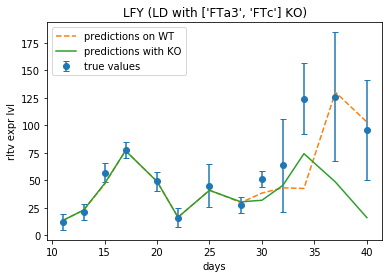

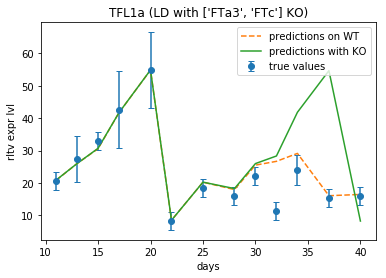

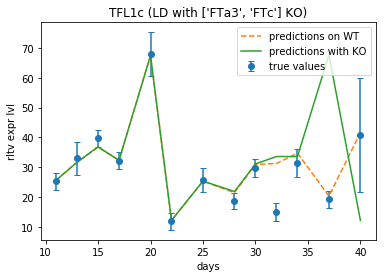

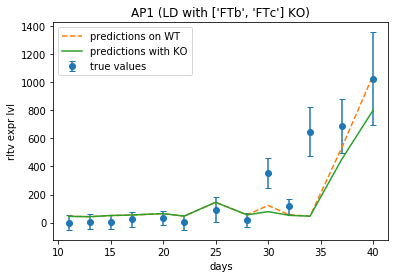

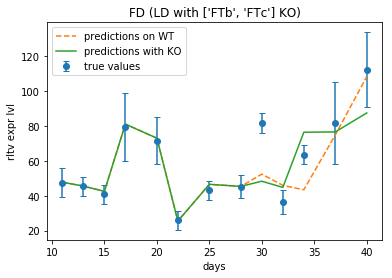

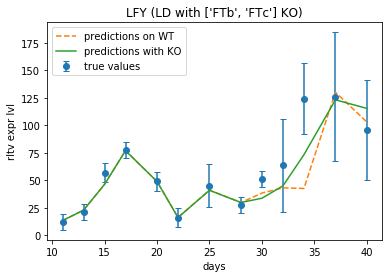

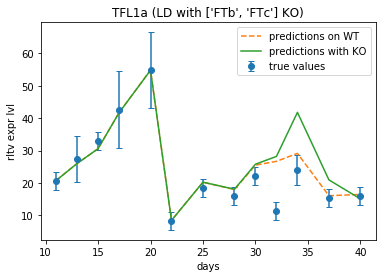

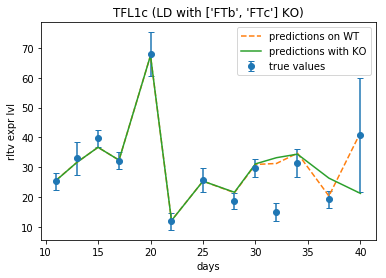

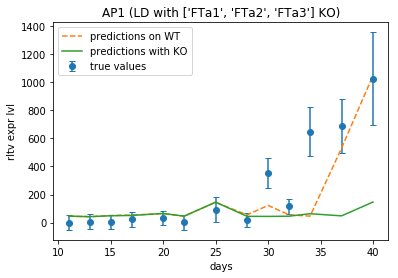

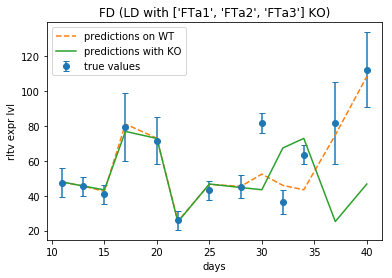

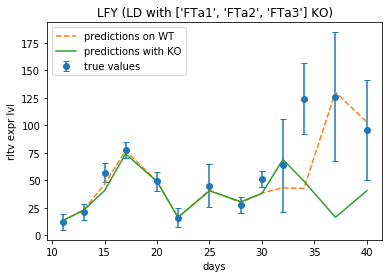

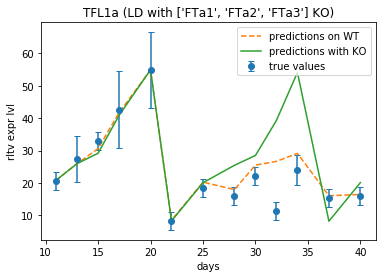

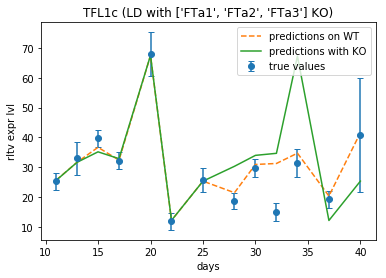

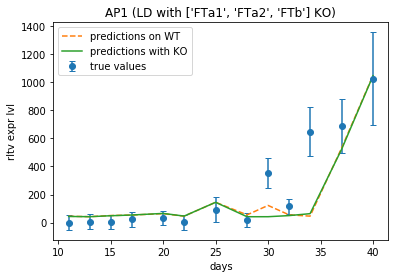

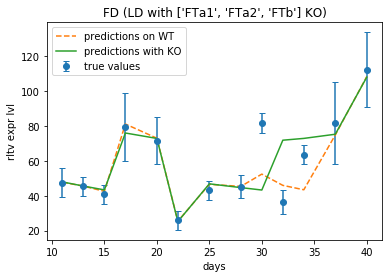

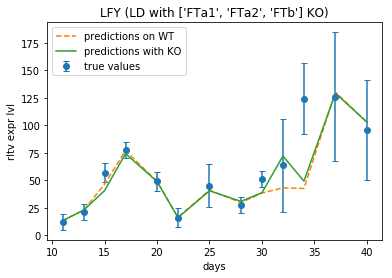

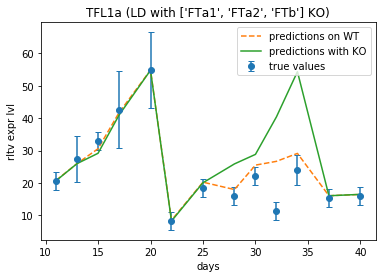

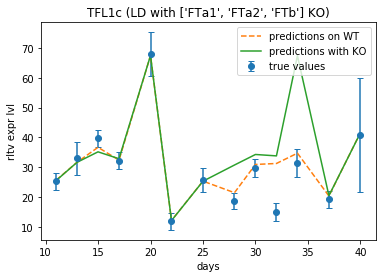

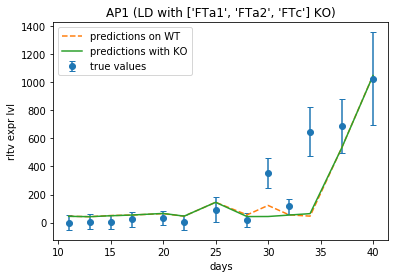

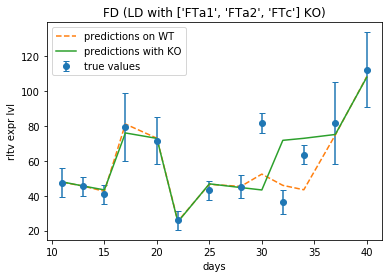

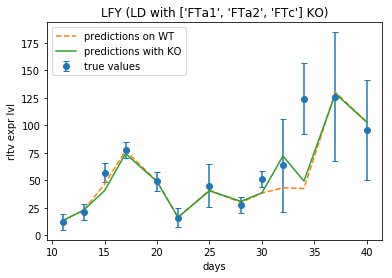

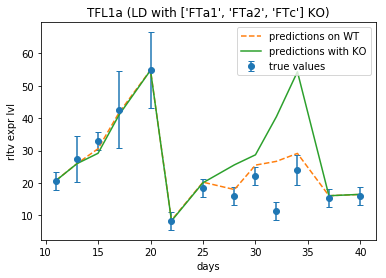

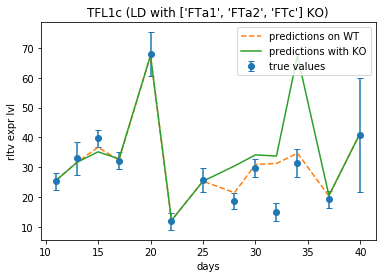

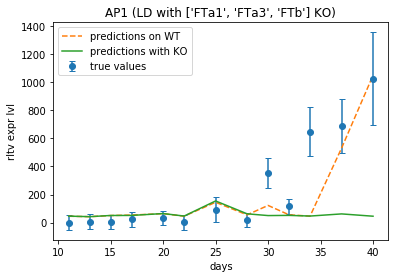

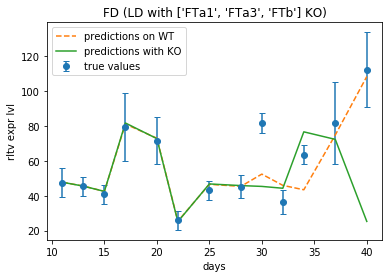

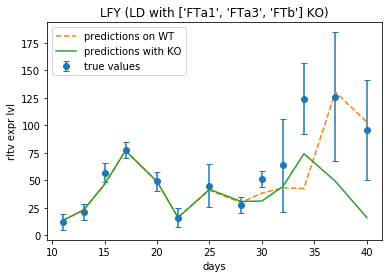

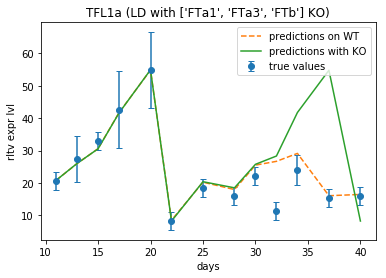

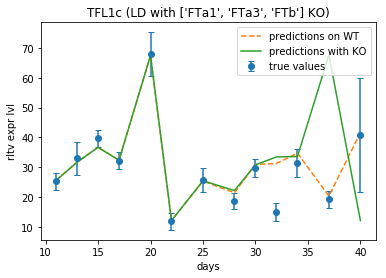

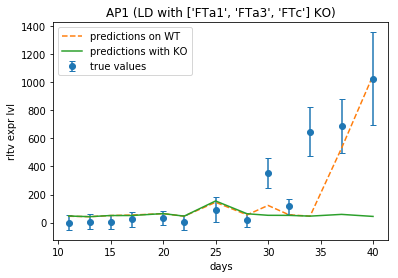

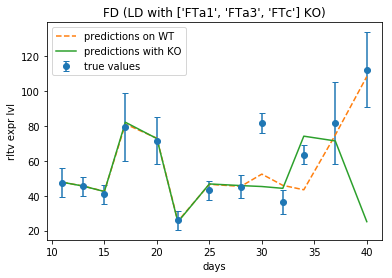

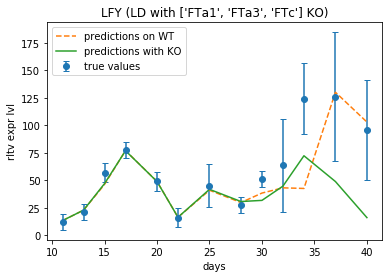

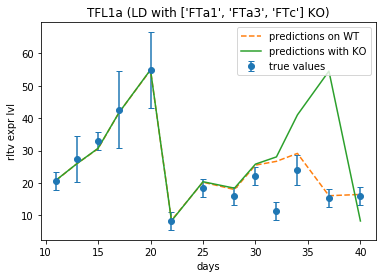

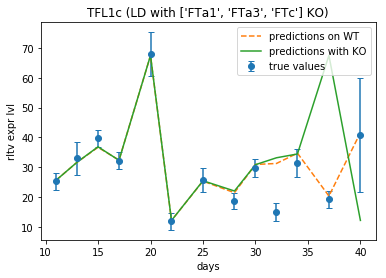

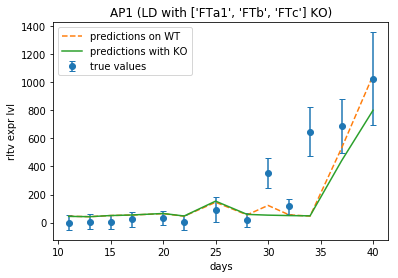

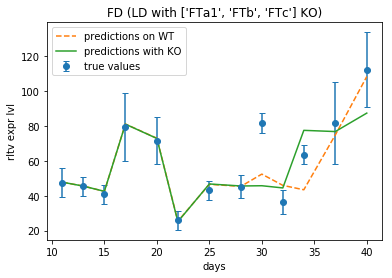

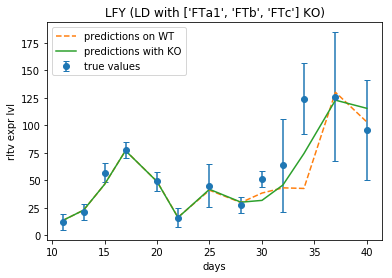

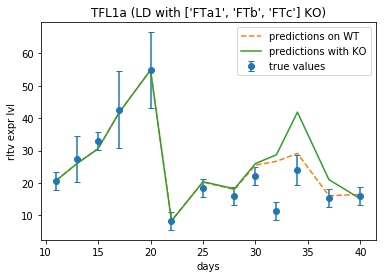

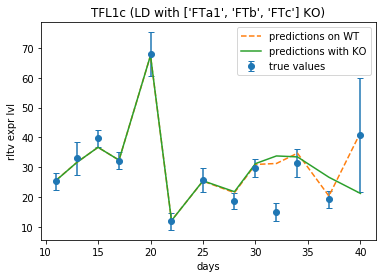

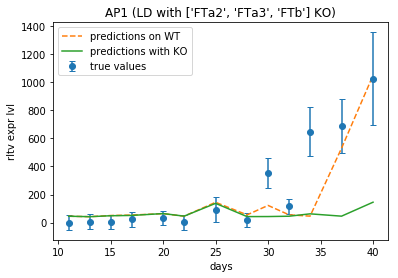

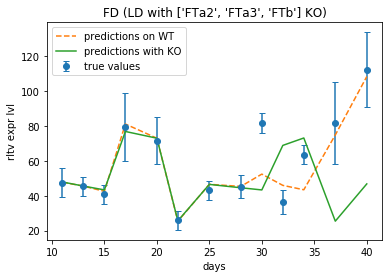

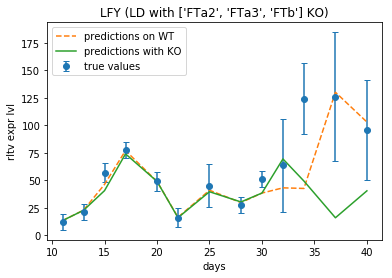

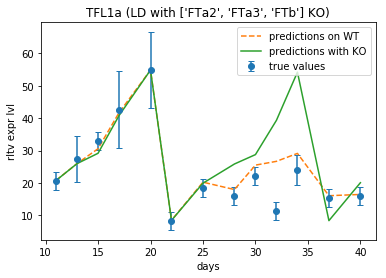

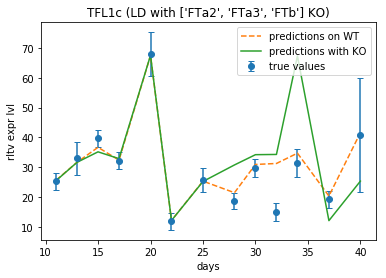

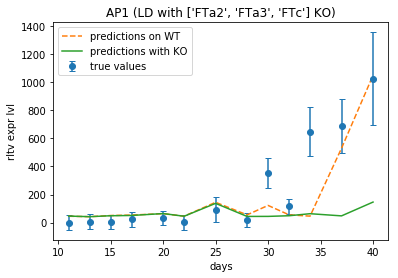

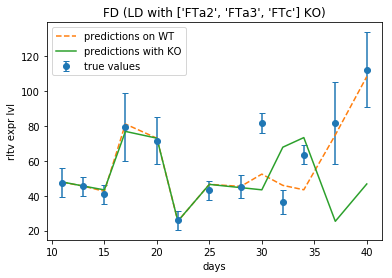

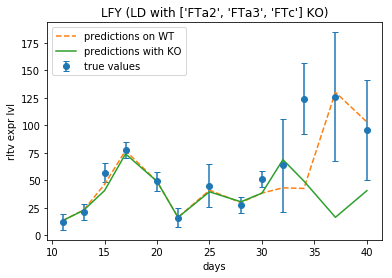

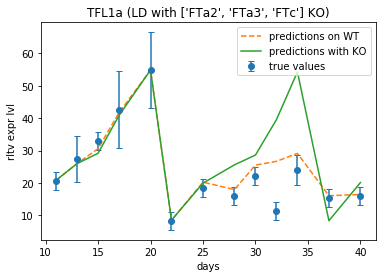

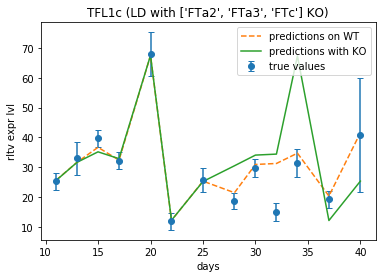

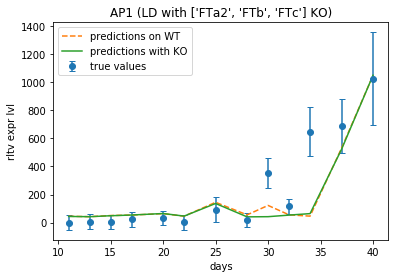

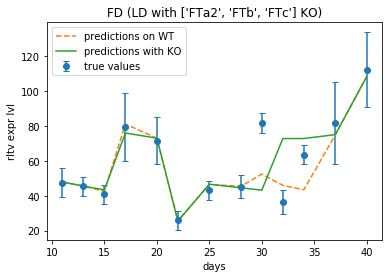

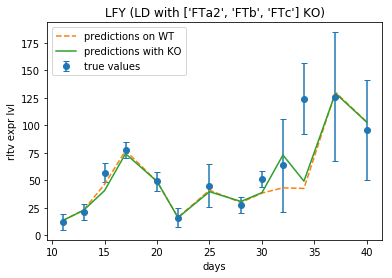

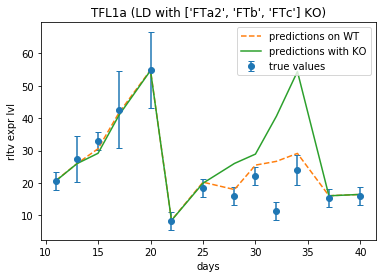

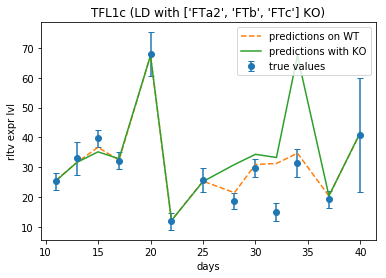

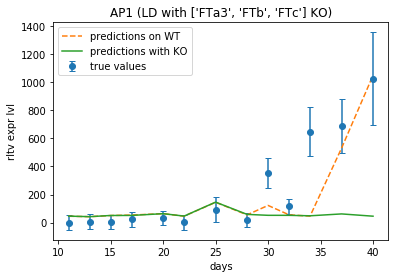

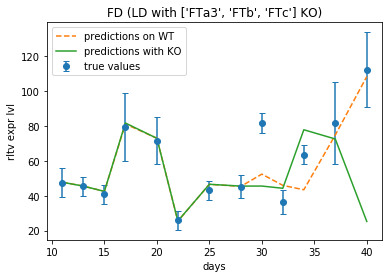

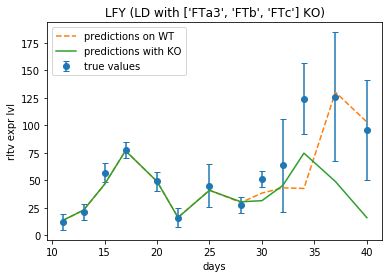

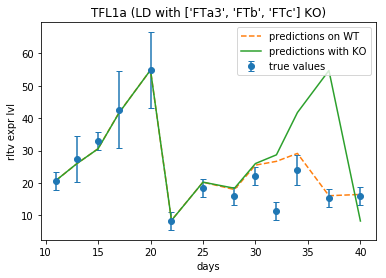

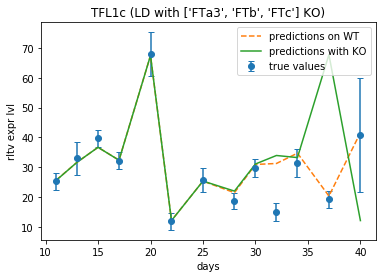

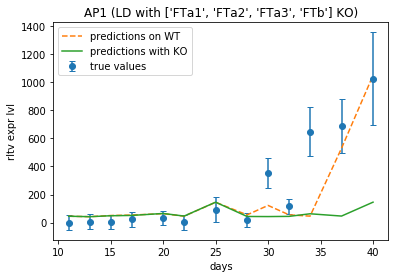

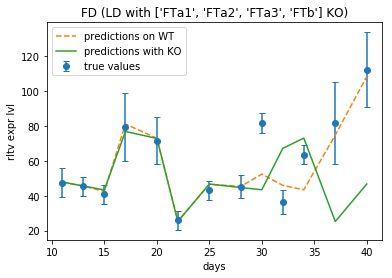

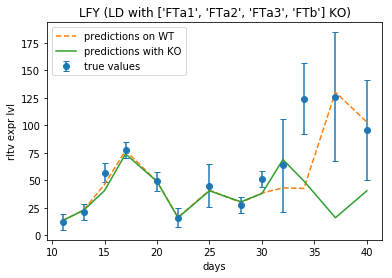

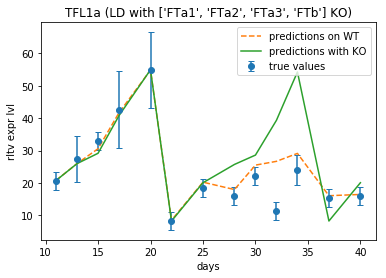

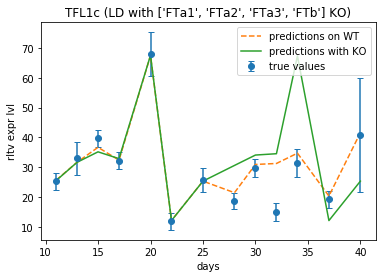

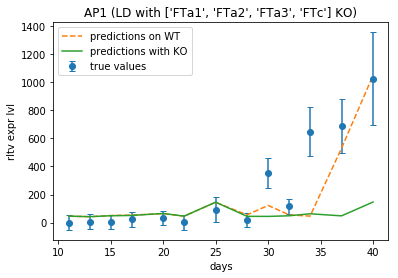

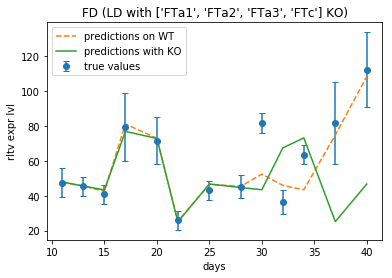

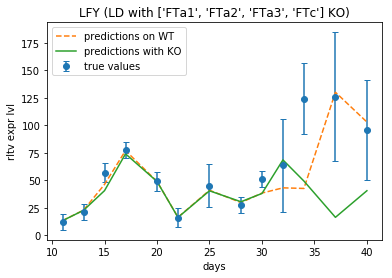

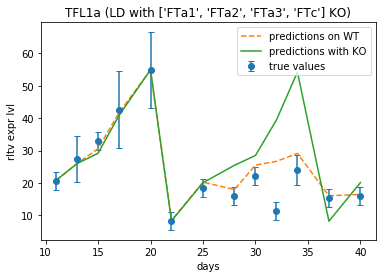

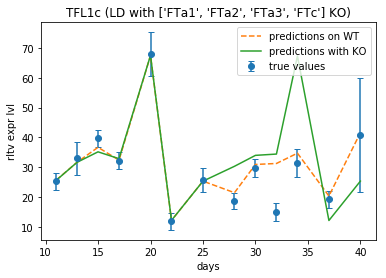

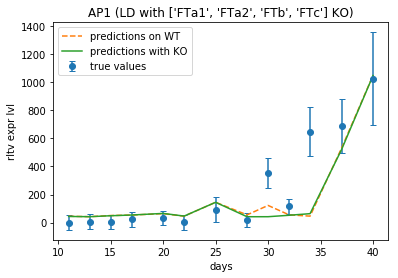

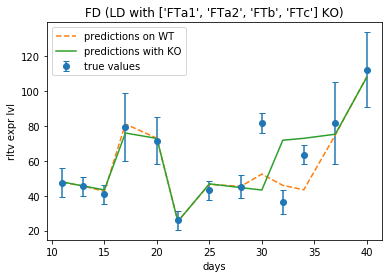

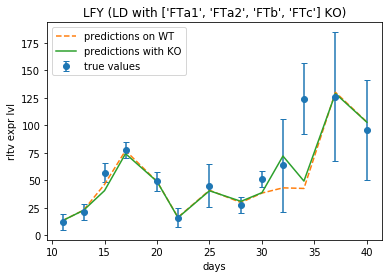

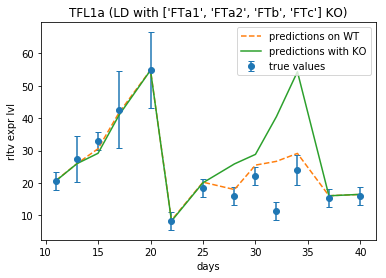

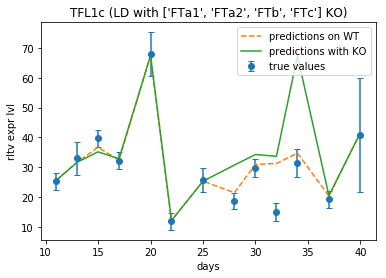

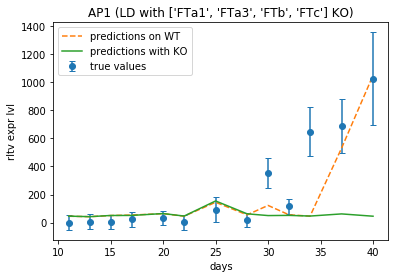

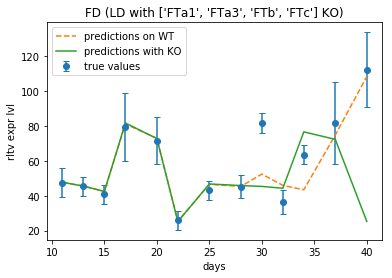

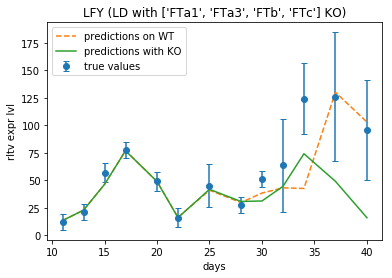

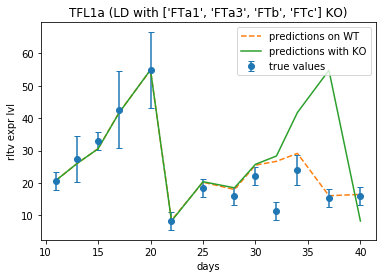

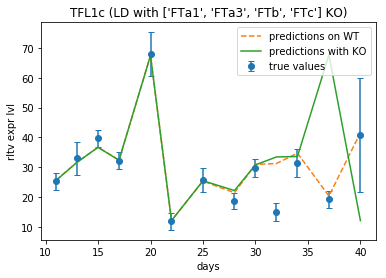

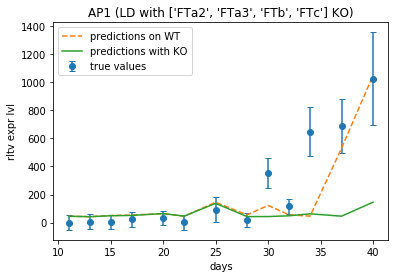

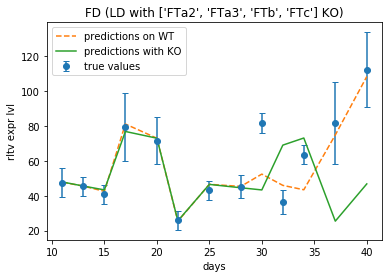

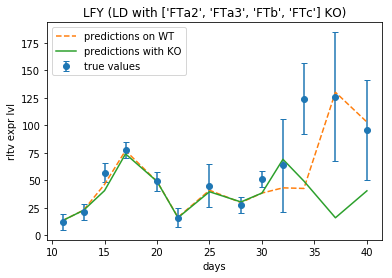

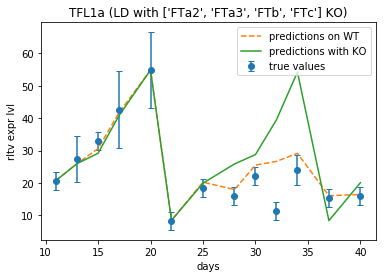

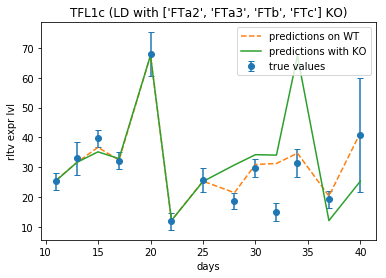

In [25]:
for ko_genes in KO_iterations:
    for cond in conditions:
        for ko_name in ko_genes:

            X_ko = X_real[cond].copy()
            X_ko = X_ko.drop('days', axis = 1)

            pred_ko = [0 for i in range(len(X_ko))]
            
            column = ko_name
            
            if type(ko_name) != type(''):
                ko_name = list(ko_name)
                column = '_'.join(ko_name)
            
            # predictions with KOs:
            for i in range(len(X_ko)):
                X_ko[ko_name] = 0
                pred_ko[i] = best_model.predict(X_ko.iloc[i, :].values.reshape(1, -1))
                X_ko[targets] = pred_ko[i][0]

            pred_ko = np.array(pred_ko).squeeze()
            
            # plots:
            time_long_plot_ko(Y_real[cond], predictions_real[cond], pred_ko, KO_gene=ko_name, condition=cond)
            
            # AUCs table:
            days_axis = Y_real[cond]['days']
            for i in range(5):
                current_target = targets[i] + '_' + cond
                AUC.loc[current_target, 'WT'] = auc(days_axis, predictions_real[cond].iloc[:, i])
                AUC.loc[current_target, column] = auc(days_axis, pred_ko[:, i])

In [ ]:
AUC.T

# FT dynamics

In [ ]:
FTs

In [ ]:
X_real['LD']

In [ ]:
for f in FTs:
    plt.plot(X_real['LD'].days, X_real['LD'][f], '-o')
    plt.legend(FTs)

In [ ]:
plt.plot(X_real['LD'].days, X_real['LD']['A'], '-o')
plt.plot(X_real['LD'].days, X_real['LD']['FTa2'], '-o')
plt.legend(['LFY', 'FTa2'])

# AUCs barplots

In [ ]:
# AUC = pd.read_csv('results/AUCs.csv', index_col = 0, sep=';')

In [92]:
AUC.T

AP1_LD  FD_LD  LFY_LD  TFL1a_LD  TFL1c_LD
WT       0      0       0         0         0

In [7]:
AUC.index[-5:]

Index(['AP1_SD', 'FD_SD', 'LFY_SD', 'TFL1a_SD', 'TFL1c_SD'], dtype='object')

In [8]:
AUC = AUC.drop(AUC.index[-5:])

In [9]:
AUCs_norm = AUC.T / AUC.WT

In [6]:
for col in AUCs_norm.columns:
    AUCs_norm.loc[col[:-3], col] = 1.

## Heatmap

In [24]:
def my_heatmap(data, figsize = (15, 5), square = False, format='svg'):
    
    plt.figure(figsize=figsize)
    
    sns.heatmap(data, robust = True, center=1, cmap='RdBu_r')
    plt.xlabel('KO genes')
    plt.ylabel('AUC relative to WT AUC')
    
    fig_path = results_path + 'dynamic/'

    if not os.path.exists(fig_path):
        os.makedirs(fig_path)

    plt.savefig(fig_path + f'Heatmap.{format}', bbox_inches='tight', format=format, dpi=300)

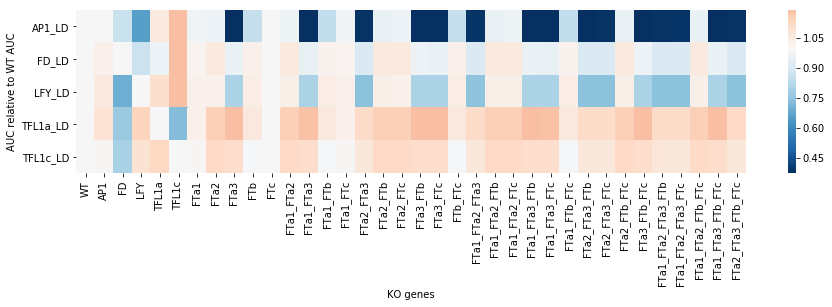

In [25]:
my_heatmap(AUCs_norm.T, figsize=(15, 3))

## Barplots

In [1]:
def AUC_barplots(dataframe, format='svg'):
    for index in dataframe.index:
        df = dataframe.drop([index[:-3], 'WT'], axis=1)
        df.loc[index] = df.loc[index] / dataframe.loc[index, 'WT']
        col = df.columns
        
        plt.figure(figsize=(20,10))

        myplot = sns.barplot(y = index, x = col, data = df.T)
        plt.xticks(rotation=60)
        plt.xlabel('KO genes')
        plt.ylabel('KO/WT transcription level')
        plt.title(index.replace('_', ' '))
        myplot.axes.axhline(1, dashes=(5, 1))
        
        fig_path = results_path + 'dynamic/barplots/'
        
        if not os.path.exists(fig_path):
            os.makedirs(fig_path)
        
        plt.savefig(fig_path + f'{index}.{format}', bbox_inches='tight', format=format, dpi=300)
        plt.show()

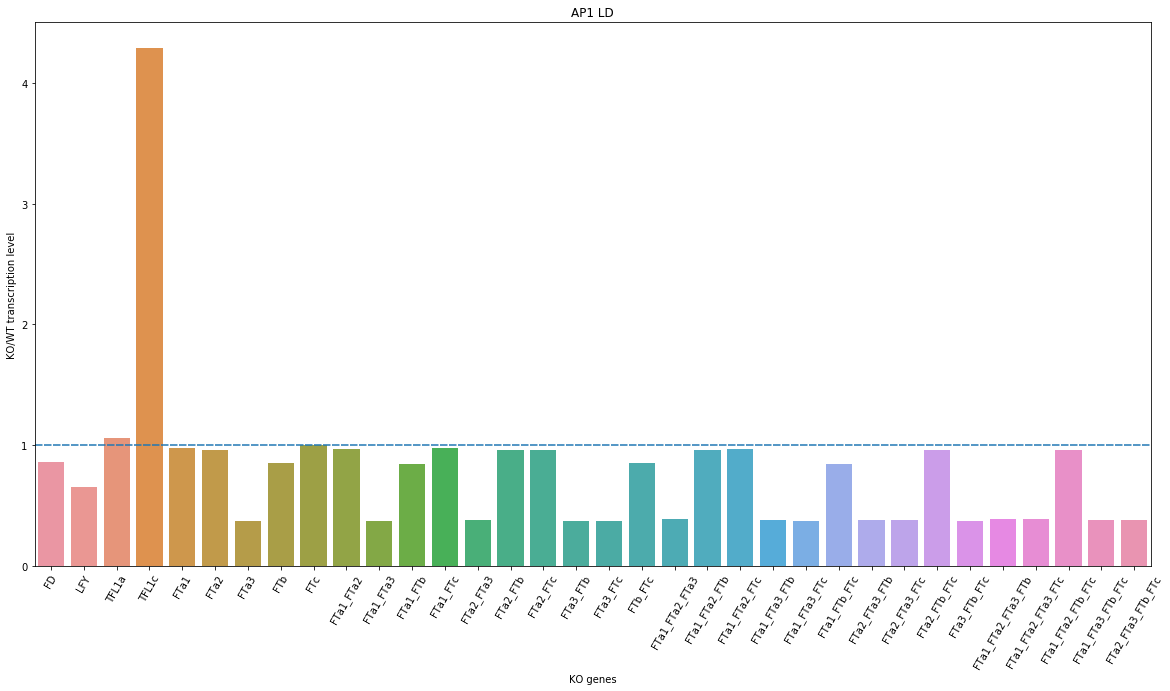

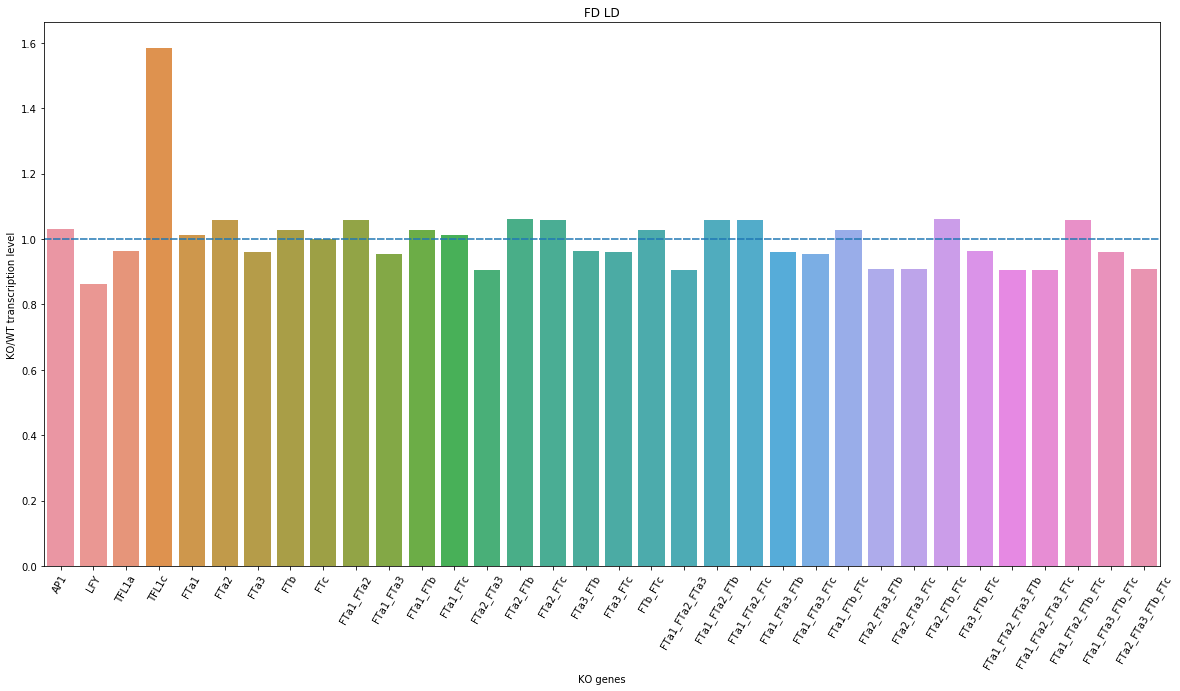

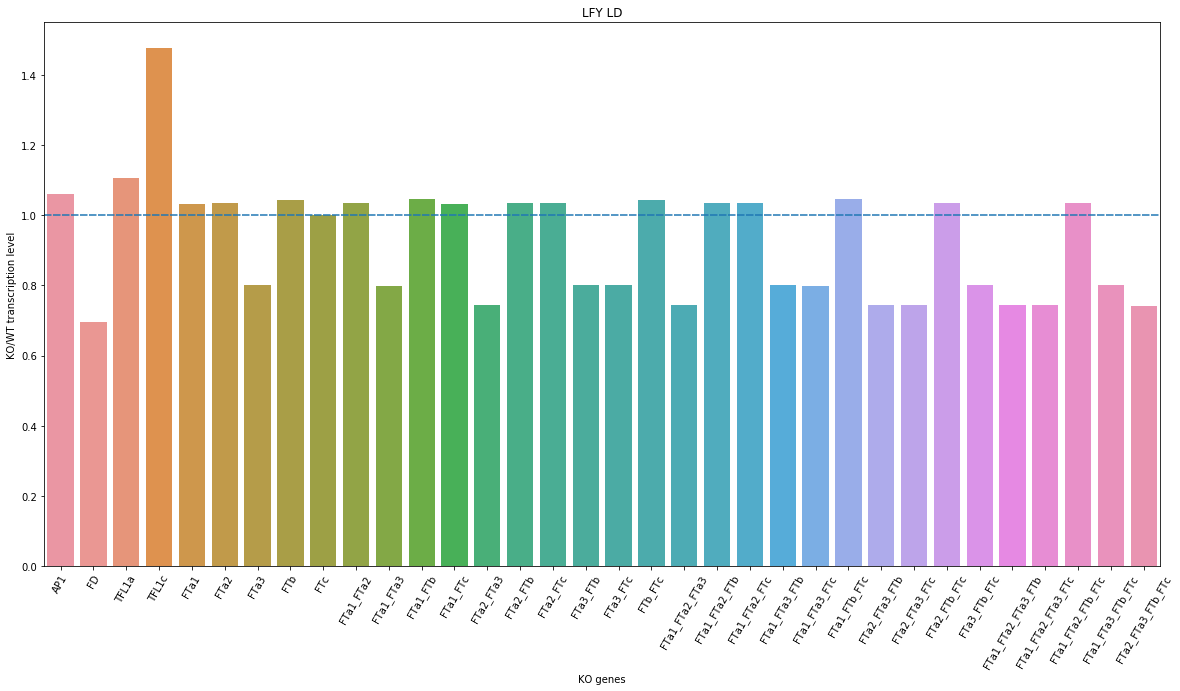

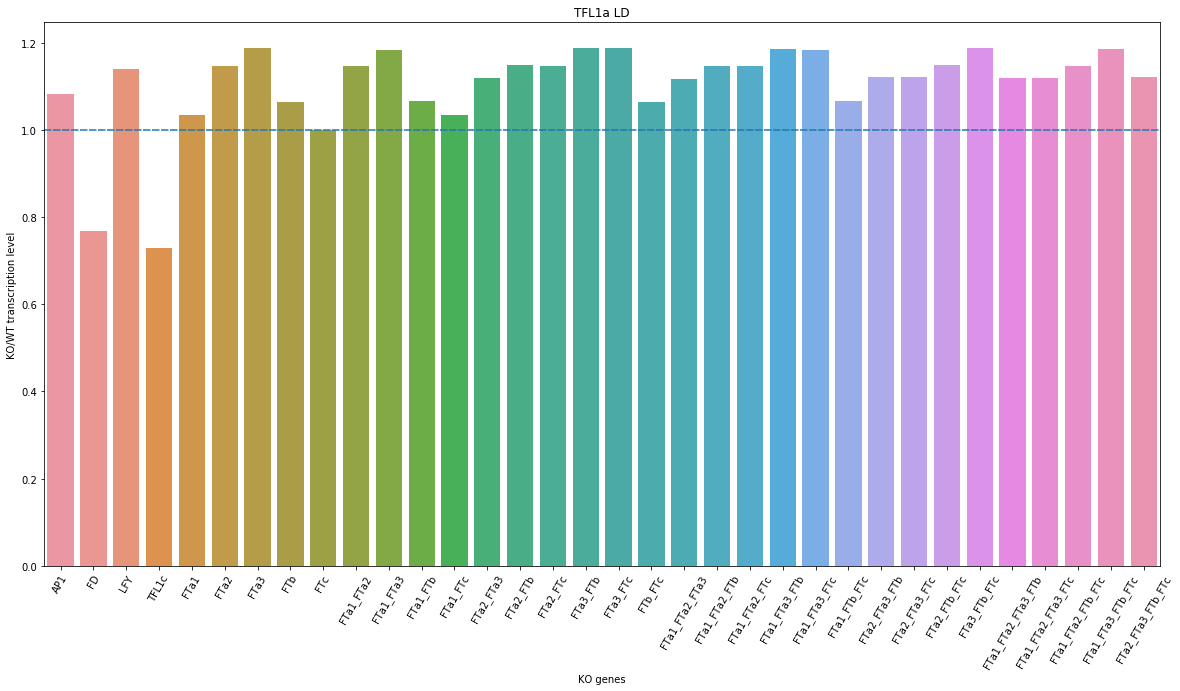

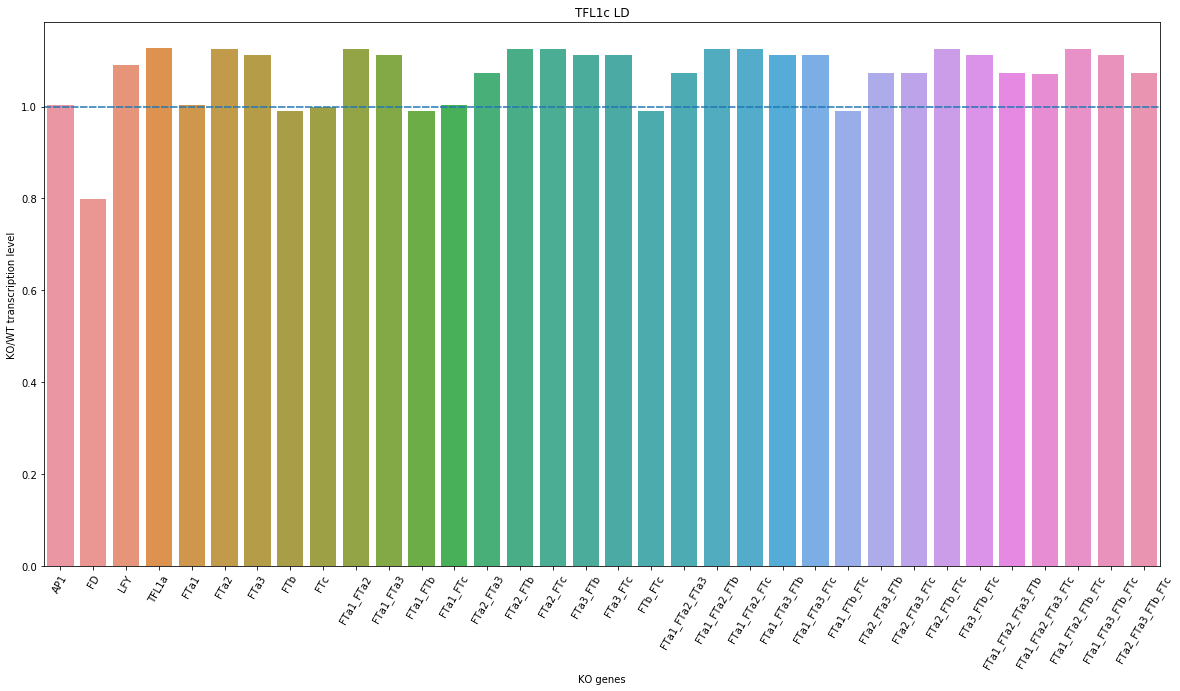

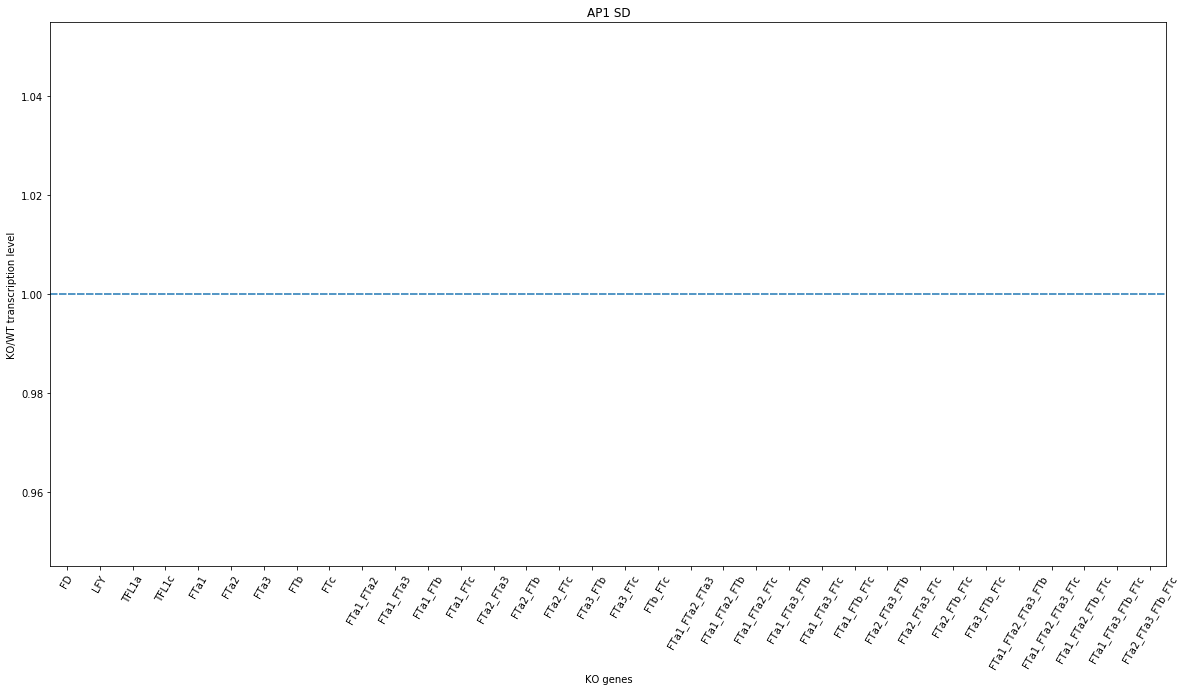

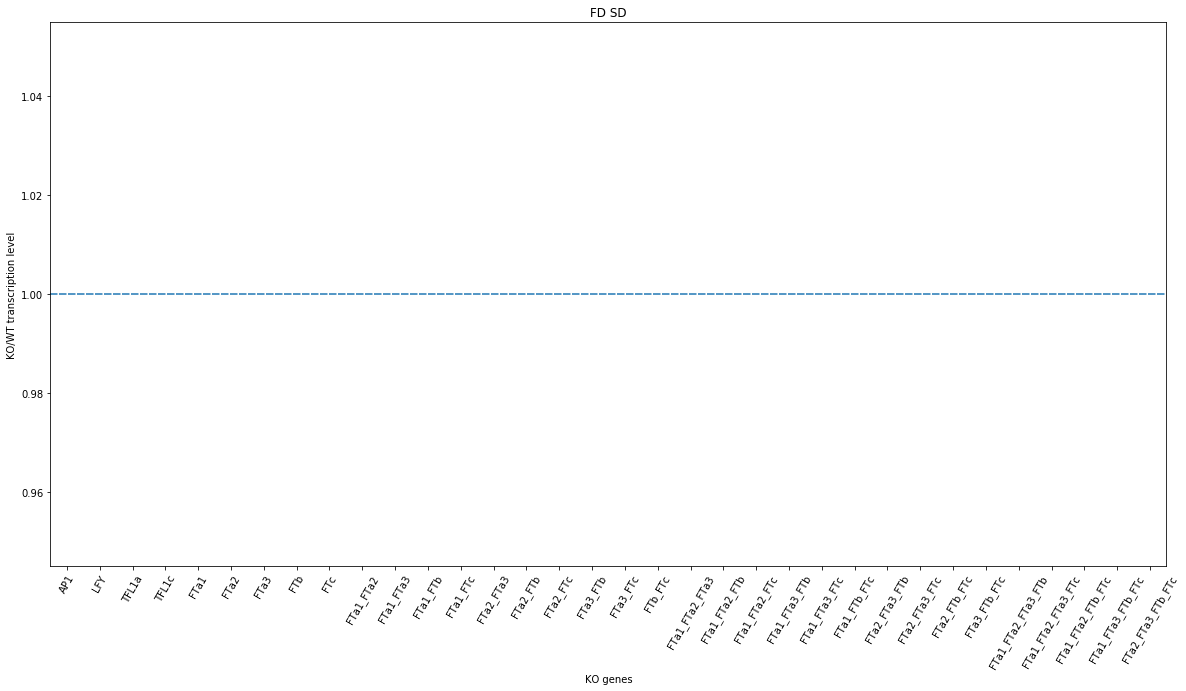

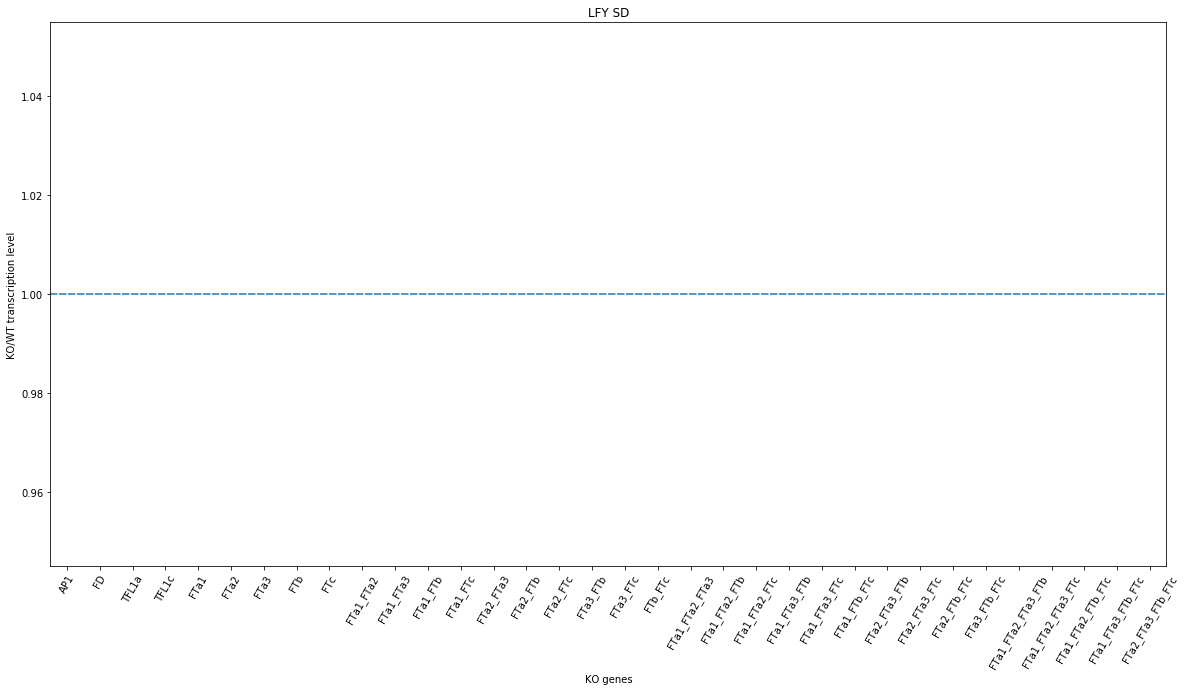

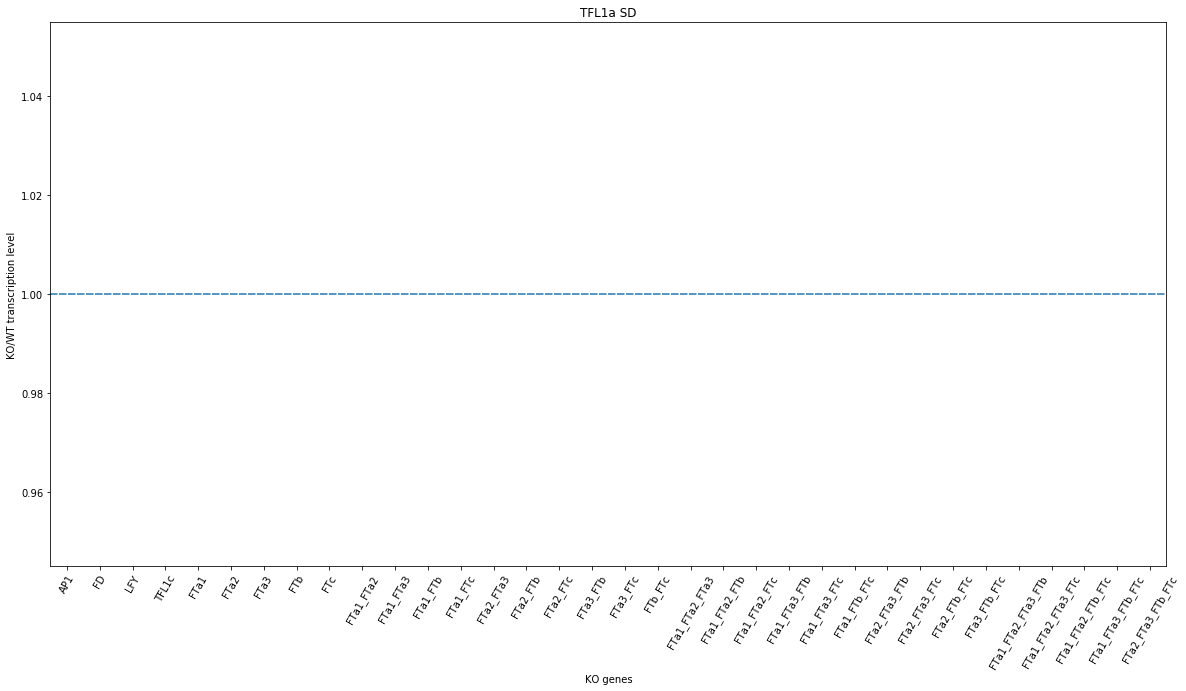

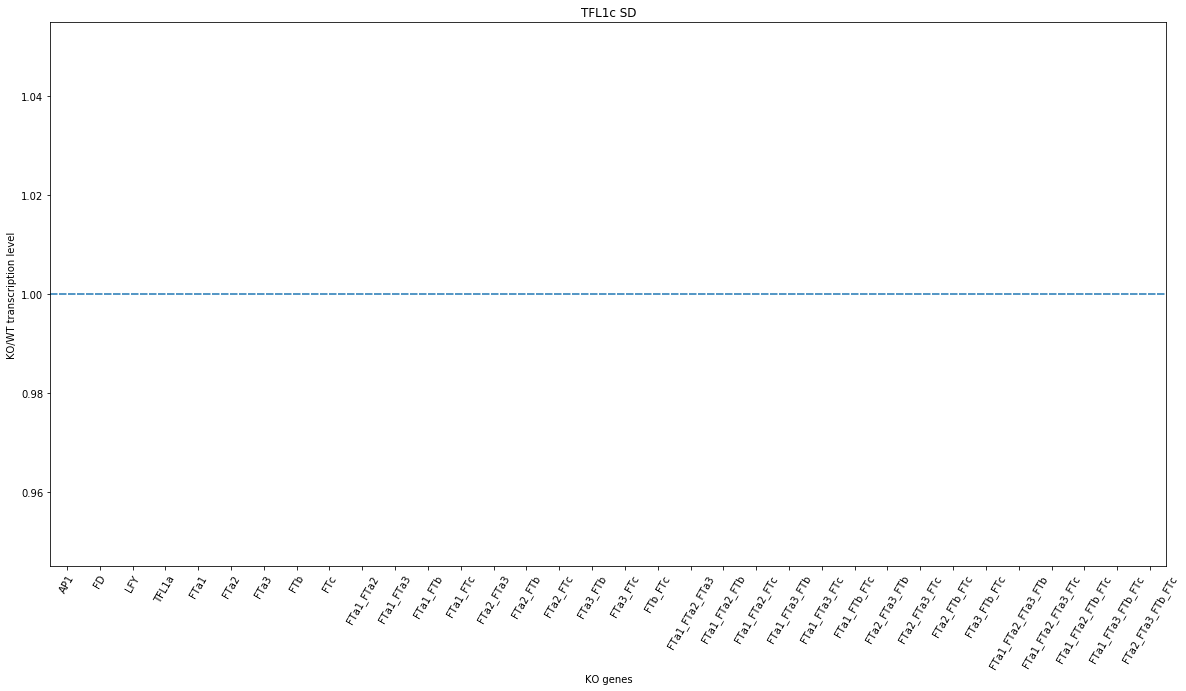

In [8]:
AUC_barplots(AUC)

In [ ]:
for f in ['FTb', 'FTa1', 'FTa3', 'FTa1_FTb']:
    myplot = sns.barplot(y = (AUC.T.loc[f,]/AUC.T.loc['WT',]).tolist(), x = AUC.T.columns)
    plt.xticks(rotation=60)
    myplot.axes.axhline(1, dashes=(5, 1))
    plt.title(f)
    plt.show()

# Save and load the model

In [26]:
dill.dump_session('cache/RandomForest_LD_only.db')

In [3]:
dill.load_session('cache/RandomForest_LD_only.db')